In [150]:
#!pip install Image
#!pip install imagesize
from IPython.display import Image
import os.path
import imagesize
def get_img(name):
    path = "/Users/csg/HomeWorkspace/git/DL-scratch2/deep_learning_2_images/{}.png".format(name)
    width, height = imagesize.get(path)
    return Image(path, width=width*0.5,  height=height*0.5)
#get_img("fig 1-1")

* 입력값: $x_t = (x_0, x_1, x_2, ..., x_t,...)$

* 출력값: $h_t = (h_0, h_1, h_2, ..., h_t,...)$

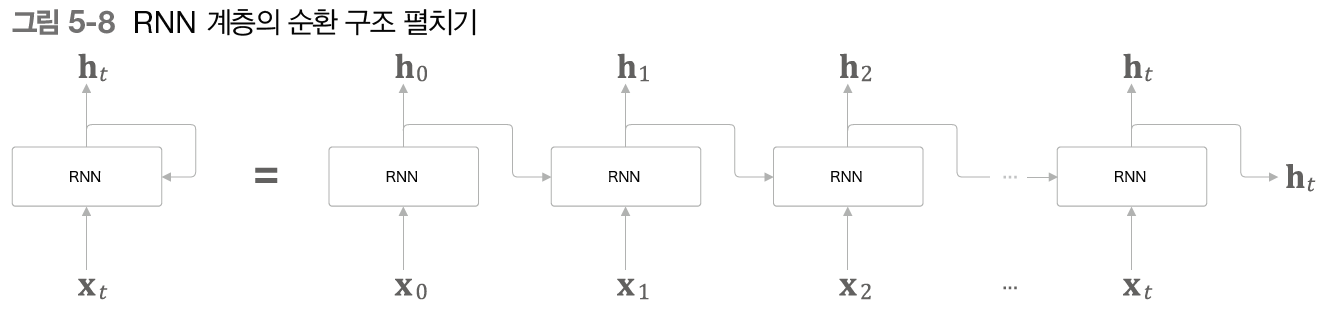

In [151]:
get_img("fig 5-8")

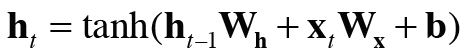

In [152]:
get_img("e 5-9")

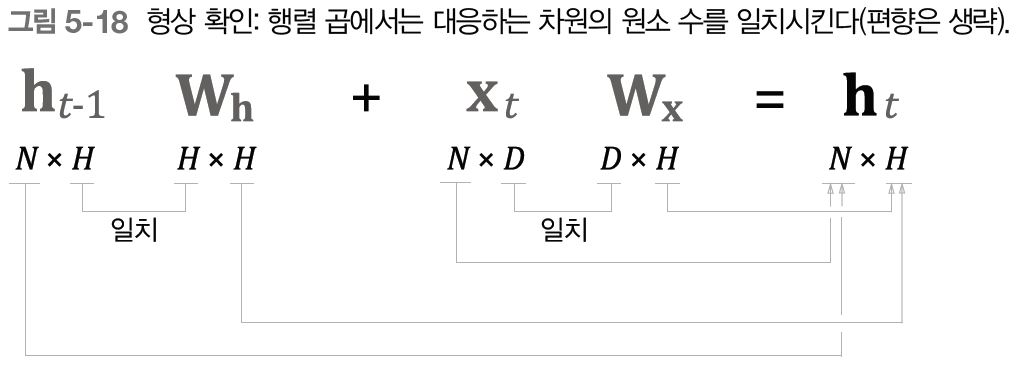

In [153]:
get_img("fig 5-18")

$N$ = 미니배치 크기,
$D$ = 입력 벡터 차원수,
$H$ = 은닉 상태 벡터 차원수
* 입력값 $x = (N, D)$
* 입력값 $h = (D, H)$
* 가중치 $W_x = (D, H)$
* 가중치 $W_h = (H, H)$

In [154]:
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기

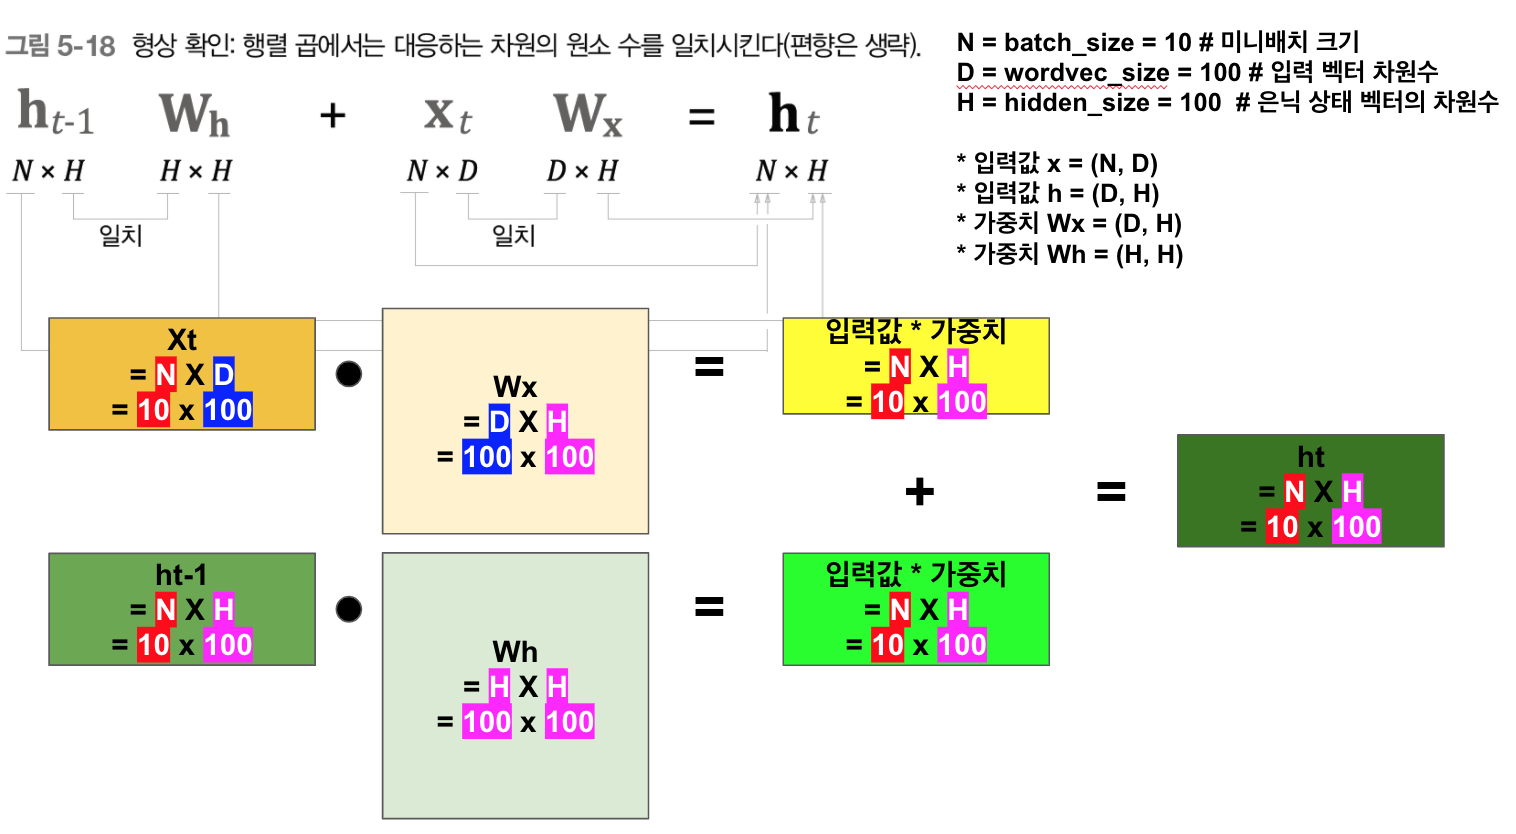

In [155]:
get_img("rnn_input")

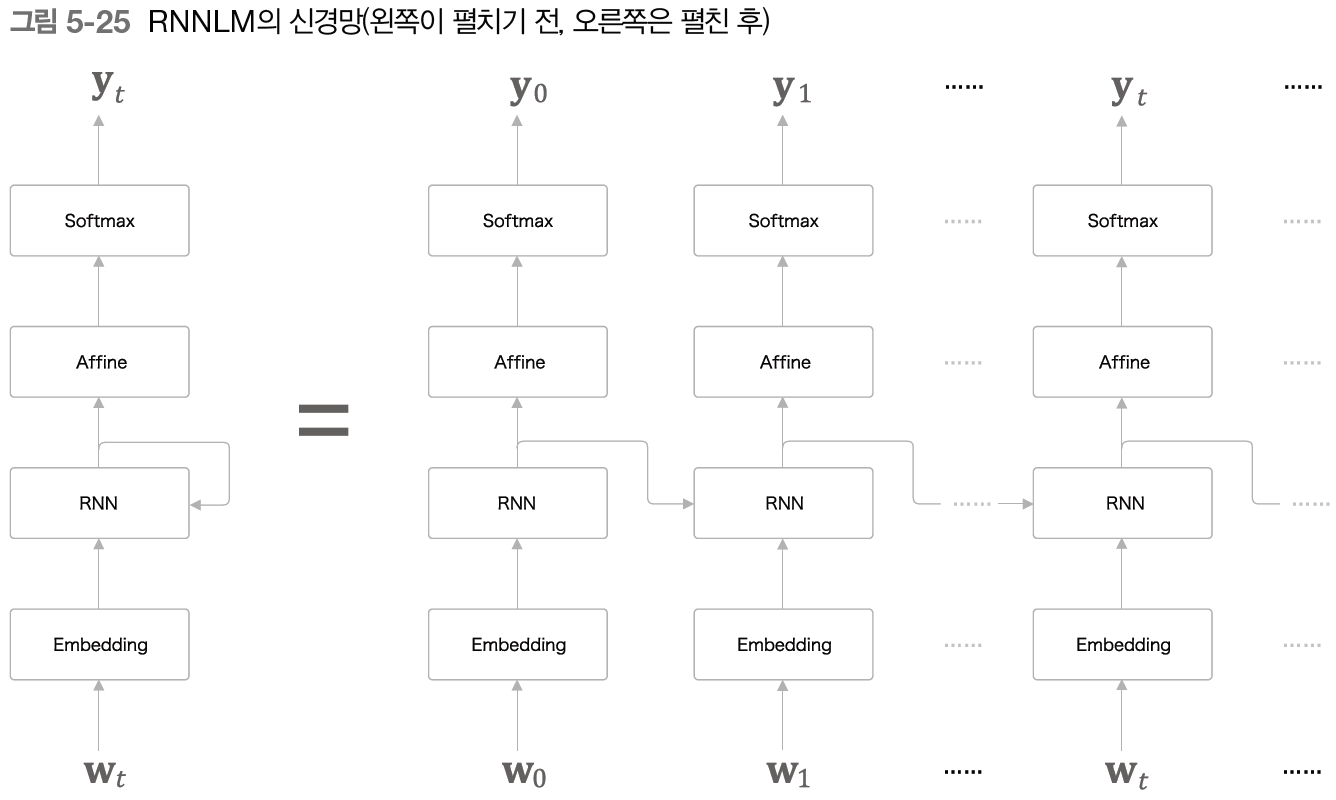

In [156]:
get_img("fig 5-25")

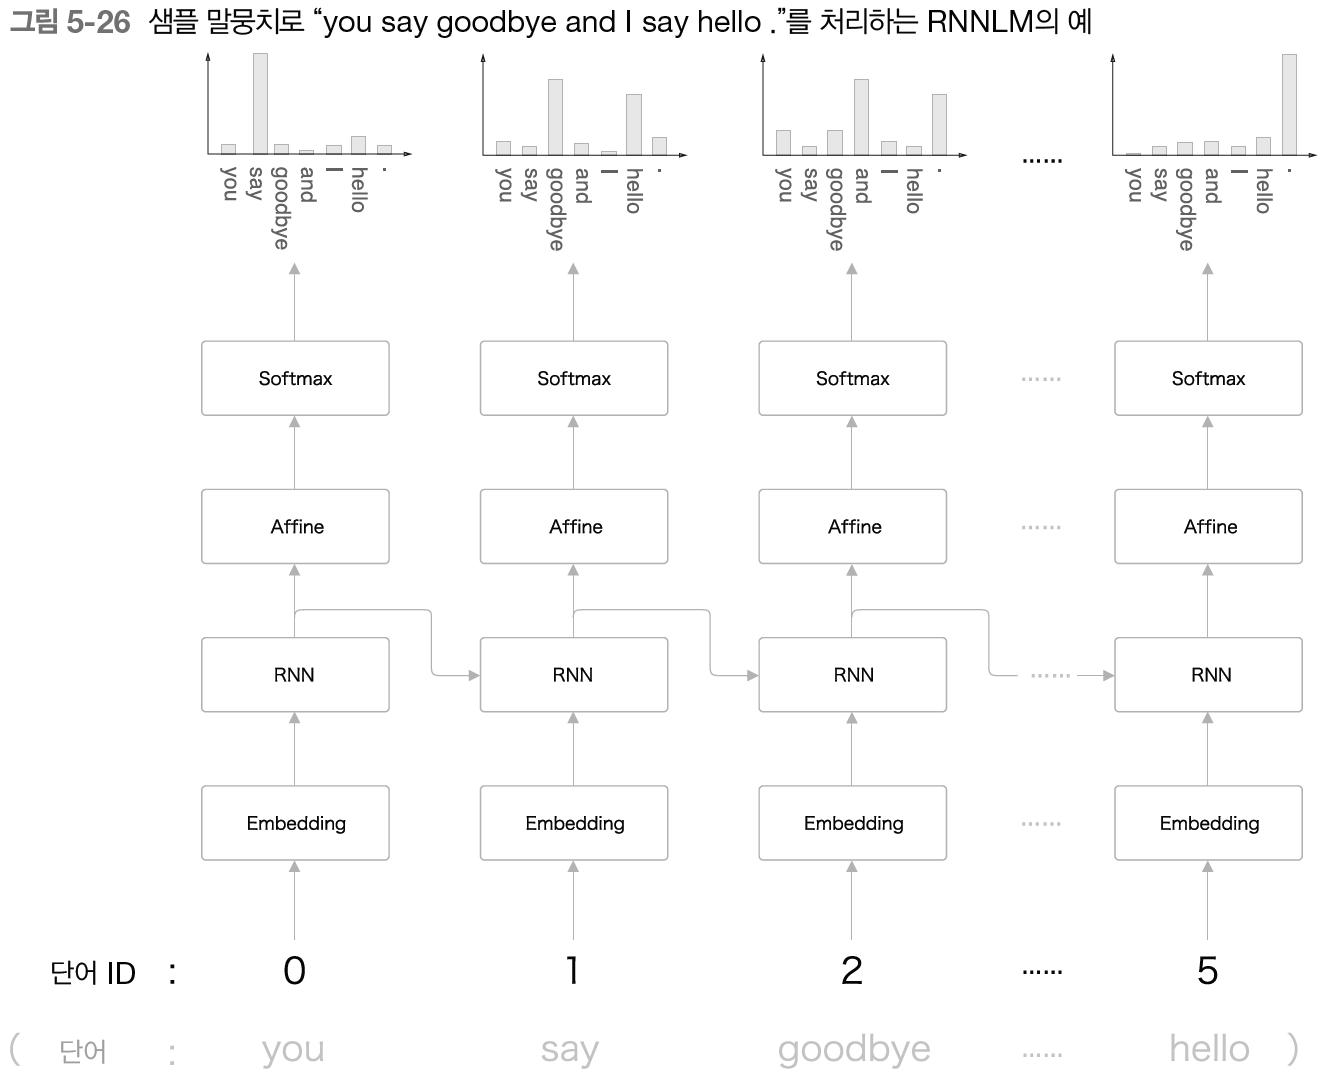

In [157]:
get_img("fig 5-26")

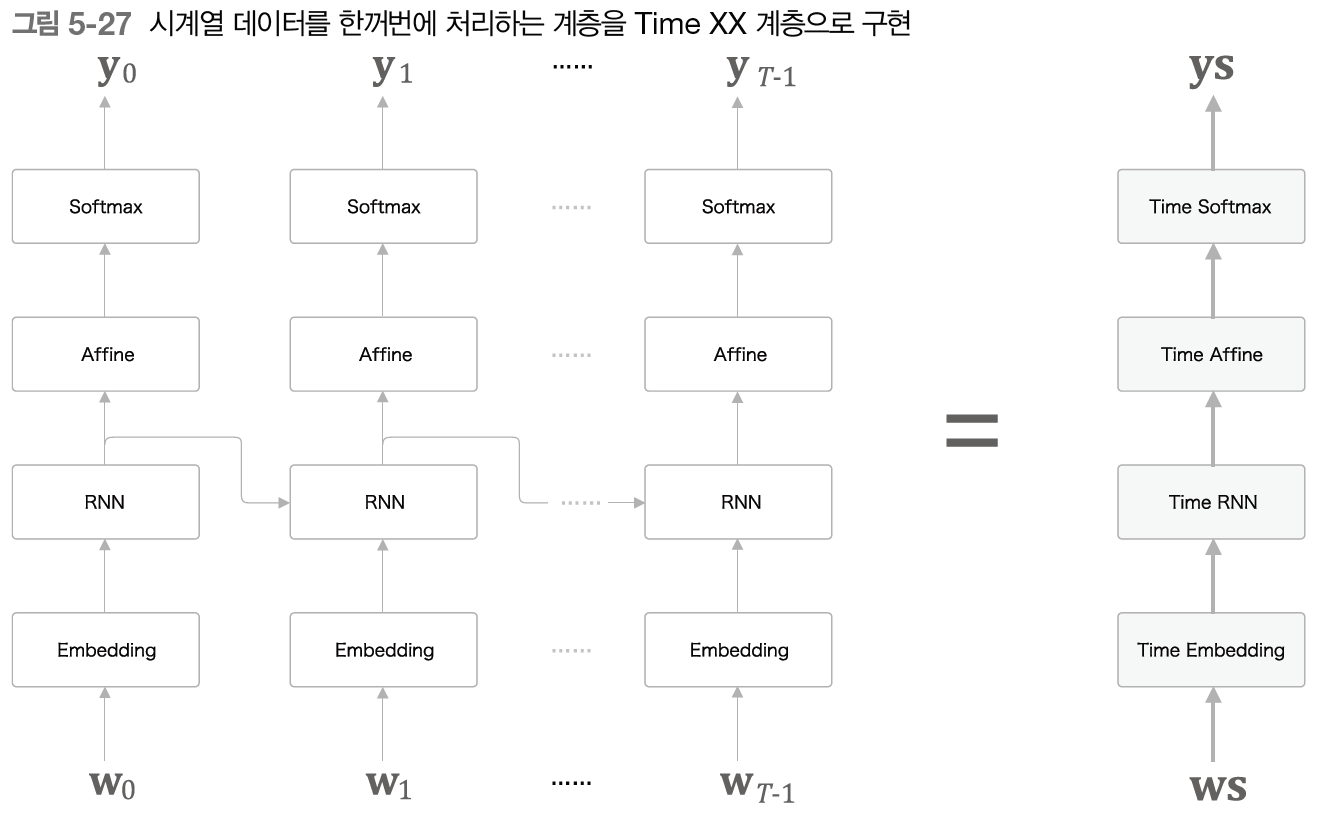

In [158]:
get_img("fig 5-27")

In [117]:
# N = batch_size = 10
# T = time_size = 5 # RNN을 펼치는 크기
# V = vocab_size = 418
# D = wordvec_size = 100
# H = hidden_size = 100 # RNN의 은닉 상태 벡터의 차원수

# common_Embedding

In [118]:
class Embedding:
    def __init__(self, W):
        #print("Embedding init W:", W.shape) # Embedding init W: (418, 100)
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        #print("Embedding forward out:", out.shape) # Embedding forward out: (10, 100)
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

# common_TimeEmbedding

In [119]:
class TimeEmbedding:
    def __init__(self, W):
        print("TimeEmbedding init W:", W.shape)
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W # (418, 100) -> (vocab_size, wordvec_size)


    def forward(self, xs):
        # N = batch_size = 10
        # T = time_size = 5
        # V = vocab_size = 418
        # D = wordvec_size = 100
        
        N, T = xs.shape # (10, 5) -> (batch_size, time_size)
        V, D = self.W.shape # (418, 100) -> (vocab_size, wordvec_size)
        #print("TimeEmbedding N:", N) # 10 -> batch_size
        #print("TimeEmbedding T:", T) # 5 -> time_size
        #print("TimeEmbedding V:", V) # 418 -> vocab_size
        #print("TimeEmbedding D:", D) # 100 -> wordvec_size

        out = np.empty((N, T, D), dtype='f')
        #print("TimeEmbedding out:", out.shape) # (10, 5, 100) -> (batch_size, time_size, wordvec_size)
        
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        # N = batch_size = 10
        # T = time_size = 5
        # D = wordvec_size = 100
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

# common_RNN

In [115]:
class RNN:
    def __init__(self, Wx, Wh, b):
        # Wx  = (100, 100) -> (wordvec_size, hidden_size)
        # Wh = (100, 100) -> (hidden_size, hidden_size)
        # b = (100,) -> (hidden_size, )
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        
        # 내적
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        
        # 활성화 함수
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    # check??? -> 순서
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2) # h_next에 대해 계산

        # 기울기
        dWx = np.dot(x.T, dt)
        dWh = np.dot(h_prev.T, dt) # h_prev에 대해 계산
        db = np.sum(dt, axis=0)
        
        # 기울기 갱신값 저장
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        # 반환값 
        dx = np.dot(dt, Wx.T) # Wx에 대해 계산
        dh_prev = np.dot(dt, Wh.T) #Wh에 대해 계산
        
        return dx, dh_prev

In [ ]:
"""
def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)

    dWh = np.dot(h_prev.T, dt)
    dh_prev = np.dot(dt, Wh.T)

    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)

    # 기울기 업데이트
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev
"""

# common_TimeRNN

In [116]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        # Wx  = (100, 100) -> (wordvec_size, hidden_size)
        # Wh = (100, 100) -> (hidden_size, hidden_size)
        # b = (100,) -> (hidden_size, )
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h = None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        # N = batch_size = 10
        # T = time_size = 5
        # D = wordvec_size = 100
        # H = hidden_size = 100
        Wx, Wh, b = self.params
        N, T, D = xs.shape # (10, 5, 100) -> (batch_size, time_size, wordvec_size)
        D, H = Wx.shape # (100, 100) -> (wordvec_size, hidden_size)

        self.layers = []
        hs = np.empty((N, T, H), dtype='f') # (10, 5, 100) -> (batch_size, time_size, hidden_size)

        if not self.stateful or self.h is None:
            # N = batch_size = 10
            # H = hidden_size = 100
            self.h = np.zeros((N, H), dtype='f') #(10, 100) -> (batch_size, hidden_size)

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs 

    def backward(self, dhs):
        # N = batch_size = 10
        # T = time_size = 5
        # D = wordvec_size = 100
        # H = hidden_size = 100
        Wx, Wh, b = self.params 
        N, T, H = dhs.shape # (10, 5, 100) -> (batch_size, time_size, hidden_size)
        D, H = Wx.shape # (100, 100) -> (wordvec_size, hidden_size)

        dxs = np.empty((N, T, D), dtype='f') # (10, 5, 100) -> (batch_size, time_size, wordvec_size)
        dh = 0
        grads = [0, 0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

# common_TimeAffine

In [127]:
class TimeAffine:
    def __init__(self, W, b):
        # W = (100, 418) -> (hidden_size, vocab_size)
        # b = (418,) -> (vocab_size, )
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        #print("TimeAffine x:", x.shape) # (10, 5, 100) -> (batch_size, time_size, hidden_size)
        
        # N = batch_size = 10
        # T = time_size = 5
        # D = wordvec_size = 100
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        
        output = out.reshape(N, T, -1) #(10, 5, 418) -> (batch_size, time_size, vocab_size)
        #print("TimeAffine output:", output.shape)
        
        return output

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

# common_TimeSoftmaxWithLoss

In [142]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx

# simple_rnnlm.py

In [75]:
vocab_size = 418
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
rn = np.random.randn
V = vocab_size
D = wordvec_size
H = hidden_size

In [53]:
embed_W = (rn(V, D) / 100).astype('f')
embed_W.shape #(418, 100) -> (vocab_size, wordvec_size)

(418, 100)

In [54]:
rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
rnn_Wx.shape #(100, 100) -> (wordvec_size, hidden_size)

(100, 100)

In [55]:
rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
rnn_Wh.shape #(100, 100) -> (hidden_size, hidden_size)

(100, 100)

In [56]:
rnn_b = np.zeros(H).astype('f')
rnn_b.shape #(100,) -> (hidden_size, )

(100,)

In [57]:
affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
affine_W.shape #(100, 418) -> (hidden_size, vocab_size)

(100, 418)

In [58]:
affine_b = np.zeros(V).astype('f')
affine_b.shape #(418,) ->  -> (vocab_size, )

(418,)

In [143]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
#from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        
        V = vocab_size # 418
        D = wordvec_size # 100
        H = hidden_size #100  # RNN의 은닉 상태 벡터의 원소 수
        rn = np.random.randn

        ####################################################
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f') #(418, 100) -> (vocab_size, wordvec_size)
        
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') #(100, 100) -> (wordvec_size, hidden_size)
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f') #(100, 100) -> (hidden_size, hidden_size)
        rnn_b = np.zeros(H).astype('f') #(100,) -> (hidden_size, )
        
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') #(100, 418) -> (hidden_size, vocab_size)
        affine_b = np.zeros(V).astype('f') #(418,) -> (vocab_size, )

        ####################################################
        # 계층 생성
        self.layers = [
            # init: embed_W = (418, 100) -> (vocab_size, wordvec_size)
            # input: xs
            # output = (10, 5, 100) -> (batch_size, time_size, wordvec_size)
            TimeEmbedding(embed_W),
            
            # init
            # ---> rnn_Wx = (100, 100) -> (wordvec_size, hidden_size)
            # ---> rnn_Wh = (100, 100) -> (hidden_size, hidden_size)
            # ---> rnn_b = (100,) -> (hidden_size, )
            # output = (10, 5, 100) -> (batch_size, time_size, hidden_size)
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            
            # init
            # ---> affine_W = (100, 418) -> (hidden_size, vocab_size)
            # ---> affine_b = (418,) -> (vocab_size, )
            # output = (10, 5, 418) -> (batch_size, time_size, vocab_size)
            TimeAffine(affine_W, affine_b)
        ]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        ####################################################
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            print("-------------{}-------------".format(layer.__class__))
            print("input:", xs.shape)
            xs = layer.forward(xs)
            print("output:", xs.shape)
            
        print("-------------{}-------------".format(self.loss_layer.__class__))
        print("input xs:", xs.shape)
        print("input ts:", ts.shape)
        loss = self.loss_layer.forward(xs, ts)
        print("output:", loss)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


# train.py

In [132]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.optimizer import SGD
#from common.trainer import RnnlmTrainer
from dataset import ptb
#from simple_rnnlm import SimpleRnnlm

In [4]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100
corpus_size = 1000  # 테스트 데이터셋을 작게 설정

In [23]:
# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1) # corpus에서 max id 가진 후 +1 
print("corpus:",corpus)
print("corpus:",corpus.shape)
print("word_to_id:", len(word_to_id))
print("id_to_word:", len(id_to_word))
print("vocab_size:", vocab_size)

corpus: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  27  24  39  26  40  41  42  26  43  32  44  45  46  24  47
  26  27  28  29  48  49  41  42  50  51  52  53  54  55  35  36  37  42
  56  57  58  59  24  35  60  42  61  62  63  64  65  66  67  68  69  70
  35  71  72  42  73  74  75  35  46  42  76  77  64  78  79  80  27  28
  81  82  83  24  32  61  84  26  40  85  26  62  78  86  32  26  87  88
  89  90  64  78  91  92  93  94  95  96  97  82  98  24  26  99  32 100
  42 101 102  26 103  93 104  66 105 106 107  26 108 109  26  67  68 108
  27  24 110 111 112 113  83  79  80  35 114  81  32 115 116 117 108 118
 119 101 120 121  42 122  35 123 124  64 125 101 126  64  32 127  24  35
  26  26  98  56  40 128  29 129  24 130 131 132 133  28  81 134 135 136
  42  61 137 138 139 140  24 141  40 142  61 108 143 144 145  24 146  26
 147  32  82 148 149  32  76 113 150  42 13

In [ ]:
# check???
#corpus_ = corpus
#corpus_.sort()
#print("vocab_size max corpus:", corpus_)

In [26]:
print("corpus:",corpus)
print("corpus:",corpus.shape)

corpus: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  27  24  39  26  40  41  42  26  43  32  44  45  46  24  47
  26  27  28  29  48  49  41  42  50  51  52  53  54  55  35  36  37  42
  56  57  58  59  24  35  60  42  61  62  63  64  65  66  67  68  69  70
  35  71  72  42  73  74  75  35  46  42  76  77  64  78  79  80  27  28
  81  82  83  24  32  61  84  26  40  85  26  62  78  86  32  26  87  88
  89  90  64  78  91  92  93  94  95  96  97  82  98  24  26  99  32 100
  42 101 102  26 103  93 104  66 105 106 107  26 108 109  26  67  68 108
  27  24 110 111 112 113  83  79  80  35 114  81  32 115 116 117 108 118
 119 101 120 121  42 122  35 123 124  64 125 101 126  64  32 127  24  35
  26  26  98  56  40 128  29 129  24 130 131 132 133  28  81 134 135 136
  42  61 137 138 139 140  24 141  40 142  61 108 143 144 145  24 146  26
 147  32  82 148 149  32  76 113 150  42 13

In [27]:
xs = corpus[:-1]  # 입력 -> 맨 마지막 제외
ts = corpus[1:]  # 출력（정답 레이블） -> 맨 처음 제외
print("xs:", xs.shape)
print("xs:", xs)
print("ts:", ts.shape)
print("ts:", ts)

xs: (999,)
xs: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  27  24  39  26  40  41  42  26  43  32  44  45  46  24  47
  26  27  28  29  48  49  41  42  50  51  52  53  54  55  35  36  37  42
  56  57  58  59  24  35  60  42  61  62  63  64  65  66  67  68  69  70
  35  71  72  42  73  74  75  35  46  42  76  77  64  78  79  80  27  28
  81  82  83  24  32  61  84  26  40  85  26  62  78  86  32  26  87  88
  89  90  64  78  91  92  93  94  95  96  97  82  98  24  26  99  32 100
  42 101 102  26 103  93 104  66 105 106 107  26 108 109  26  67  68 108
  27  24 110 111 112 113  83  79  80  35 114  81  32 115 116 117 108 118
 119 101 120 121  42 122  35 123 124  64 125 101 126  64  32 127  24  35
  26  26  98  56  40 128  29 129  24 130 131 132 133  28  81 134 135 136
  42  61 137 138 139 140  24 141  40 142  61 108 143 144 145  24 146  26
 147  32  82 148 149  32  76 113 150

In [129]:
# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

TimeEmbedding init W: (418, 100)


In [130]:
trainer.fit(xs, ts, max_epoch, batch_size, time_size)

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.82
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 379.43
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 260.80
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 219.71
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 209.36
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 207.79
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.08
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.41
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.96
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.92
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.39
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.96
| 에폭 13 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 192.57
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 186.59
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 185.34
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 189.93
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.45
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 183.50
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 181.23
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 181.16
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 178.96
| 에폭 22 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 177.

In [78]:
"""
| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 418.79
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 411.17
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 325.31
| 에폭 4 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 237.07
| 에폭 5 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 214.97
| 에폭 6 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 212.89
| 에폭 7 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 203.23
| 에폭 8 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 200.95
| 에폭 9 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 196.20
| 에폭 10 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 191.32
| 에폭 11 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 191.86
| 에폭 12 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 187.97
| 에폭 13 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 191.32
| 에폭 14 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 186.54
| 에폭 15 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 185.44
| 에폭 16 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 188.64
| 에폭 17 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 187.92
| 에폭 18 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 183.10
| 에폭 19 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 180.10
| 에폭 20 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 180.79
| 에폭 21 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 176.38
| 에폭 22 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 175.25
| 에폭 23 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 177.53
| 에폭 24 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 176.11
| 에폭 25 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 168.99
| 에폭 26 |  반복 1 / 19 | 시간 9[s] | 퍼플렉서티 170.56
| 에폭 27 |  반복 1 / 19 | 시간 9[s] | 퍼플렉서티 168.03
| 에폭 28 |  반복 1 / 19 | 시간 10[s] | 퍼플렉서티 168.96
| 에폭 29 |  반복 1 / 19 | 시간 10[s] | 퍼플렉서티 164.45
| 에폭 30 |  반복 1 / 19 | 시간 11[s] | 퍼플렉서티 158.96
| 에폭 31 |  반복 1 / 19 | 시간 12[s] | 퍼플렉서티 158.14
| 에폭 32 |  반복 1 / 19 | 시간 12[s] | 퍼플렉서티 151.95
| 에폭 33 |  반복 1 / 19 | 시간 12[s] | 퍼플렉서티 153.15
| 에폭 34 |  반복 1 / 19 | 시간 13[s] | 퍼플렉서티 149.80
| 에폭 35 |  반복 1 / 19 | 시간 13[s] | 퍼플렉서티 143.89
| 에폭 36 |  반복 1 / 19 | 시간 14[s] | 퍼플렉서티 142.31
| 에폭 37 |  반복 1 / 19 | 시간 14[s] | 퍼플렉서티 141.17
| 에폭 38 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 132.60
| 에폭 39 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 132.00
| 에폭 40 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 124.16
| 에폭 41 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 121.00
| 에폭 42 |  반복 1 / 19 | 시간 16[s] | 퍼플렉서티 119.05
| 에폭 43 |  반복 1 / 19 | 시간 16[s] | 퍼플렉서티 113.11
| 에폭 44 |  반복 1 / 19 | 시간 16[s] | 퍼플렉서티 109.60
| 에폭 45 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 102.38
| 에폭 46 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 98.75
| 에폭 47 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 98.39
| 에폭 48 |  반복 1 / 19 | 시간 18[s] | 퍼플렉서티 92.47
| 에폭 49 |  반복 1 / 19 | 시간 18[s] | 퍼플렉서티 88.27
| 에폭 50 |  반복 1 / 19 | 시간 19[s] | 퍼플렉서티 82.68
| 에폭 51 |  반복 1 / 19 | 시간 19[s] | 퍼플렉서티 82.01
| 에폭 52 |  반복 1 / 19 | 시간 19[s] | 퍼플렉서티 76.13
| 에폭 53 |  반복 1 / 19 | 시간 19[s] | 퍼플렉서티 72.59
| 에폭 54 |  반복 1 / 19 | 시간 20[s] | 퍼플렉서티 69.40
| 에폭 55 |  반복 1 / 19 | 시간 21[s] | 퍼플렉서티 67.51
| 에폭 56 |  반복 1 / 19 | 시간 21[s] | 퍼플렉서티 62.82
| 에폭 57 |  반복 1 / 19 | 시간 21[s] | 퍼플렉서티 60.72
| 에폭 58 |  반복 1 / 19 | 시간 22[s] | 퍼플렉서티 56.13
| 에폭 59 |  반복 1 / 19 | 시간 23[s] | 퍼플렉서티 53.39
| 에폭 60 |  반복 1 / 19 | 시간 23[s] | 퍼플렉서티 50.05
| 에폭 61 |  반복 1 / 19 | 시간 24[s] | 퍼플렉서티 47.73
| 에폭 62 |  반복 1 / 19 | 시간 24[s] | 퍼플렉서티 46.15
| 에폭 63 |  반복 1 / 19 | 시간 25[s] | 퍼플렉서티 44.23
| 에폭 64 |  반복 1 / 19 | 시간 26[s] | 퍼플렉서티 41.17
| 에폭 65 |  반복 1 / 19 | 시간 26[s] | 퍼플렉서티 37.26
| 에폭 66 |  반복 1 / 19 | 시간 26[s] | 퍼플렉서티 36.01
| 에폭 67 |  반복 1 / 19 | 시간 27[s] | 퍼플렉서티 35.17
| 에폭 68 |  반복 1 / 19 | 시간 27[s] | 퍼플렉서티 33.11
| 에폭 69 |  반복 1 / 19 | 시간 27[s] | 퍼플렉서티 31.95
| 에폭 70 |  반복 1 / 19 | 시간 28[s] | 퍼플렉서티 28.86
| 에폭 71 |  반복 1 / 19 | 시간 28[s] | 퍼플렉서티 27.64
| 에폭 72 |  반복 1 / 19 | 시간 29[s] | 퍼플렉서티 25.70
| 에폭 73 |  반복 1 / 19 | 시간 29[s] | 퍼플렉서티 24.80
| 에폭 74 |  반복 1 / 19 | 시간 30[s] | 퍼플렉서티 23.02
| 에폭 75 |  반복 1 / 19 | 시간 30[s] | 퍼플렉서티 21.55
| 에폭 76 |  반복 1 / 19 | 시간 30[s] | 퍼플렉서티 20.87
| 에폭 77 |  반복 1 / 19 | 시간 31[s] | 퍼플렉서티 20.05
| 에폭 78 |  반복 1 / 19 | 시간 31[s] | 퍼플렉서티 19.09
| 에폭 79 |  반복 1 / 19 | 시간 31[s] | 퍼플렉서티 17.31
| 에폭 80 |  반복 1 / 19 | 시간 32[s] | 퍼플렉서티 16.58
| 에폭 81 |  반복 1 / 19 | 시간 32[s] | 퍼플렉서티 15.62
| 에폭 82 |  반복 1 / 19 | 시간 33[s] | 퍼플렉서티 14.29
| 에폭 83 |  반복 1 / 19 | 시간 33[s] | 퍼플렉서티 14.14
| 에폭 84 |  반복 1 / 19 | 시간 34[s] | 퍼플렉서티 13.44
| 에폭 85 |  반복 1 / 19 | 시간 34[s] | 퍼플렉서티 12.41
| 에폭 86 |  반복 1 / 19 | 시간 35[s] | 퍼플렉서티 11.78
| 에폭 87 |  반복 1 / 19 | 시간 35[s] | 퍼플렉서티 11.25
| 에폭 88 |  반복 1 / 19 | 시간 36[s] | 퍼플렉서티 10.80
| 에폭 89 |  반복 1 / 19 | 시간 36[s] | 퍼플렉서티 10.37
| 에폭 90 |  반복 1 / 19 | 시간 37[s] | 퍼플렉서티 10.13
| 에폭 91 |  반복 1 / 19 | 시간 37[s] | 퍼플렉서티 9.06
| 에폭 92 |  반복 1 / 19 | 시간 37[s] | 퍼플렉서티 9.09
| 에폭 93 |  반복 1 / 19 | 시간 38[s] | 퍼플렉서티 8.39
| 에폭 94 |  반복 1 / 19 | 시간 38[s] | 퍼플렉서티 8.22
| 에폭 95 |  반복 1 / 19 | 시간 38[s] | 퍼플렉서티 7.82
| 에폭 96 |  반복 1 / 19 | 시간 38[s] | 퍼플렉서티 7.44
| 에폭 97 |  반복 1 / 19 | 시간 39[s] | 퍼플렉서티 6.99
| 에폭 98 |  반복 1 / 19 | 시간 39[s] | 퍼플렉서티 6.74
| 에폭 99 |  반복 1 / 19 | 시간 39[s] | 퍼플렉서티 6.49
| 에폭 100 |  반복 1 / 19 | 시간 40[s] | 퍼플렉서티 5.94
"""

'\n| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 418.79\n| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 411.17\n| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 325.31\n| 에폭 4 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 237.07\n| 에폭 5 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 214.97\n| 에폭 6 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 212.89\n| 에폭 7 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 203.23\n| 에폭 8 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 200.95\n| 에폭 9 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 196.20\n| 에폭 10 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 191.32\n| 에폭 11 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 191.86\n| 에폭 12 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 187.97\n| 에폭 13 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 191.32\n| 에폭 14 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 186.54\n| 에폭 15 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 185.44\n| 에폭 16 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 188.64\n| 에폭 17 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 187.92\n| 에폭 18 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 183.10\n| 에폭 19 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 180.10\n| 에폭 20 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 180.79\n| 에폭 21 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 176.38\n| 에폭 22 |  반복 1 / 1

/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: Runtim

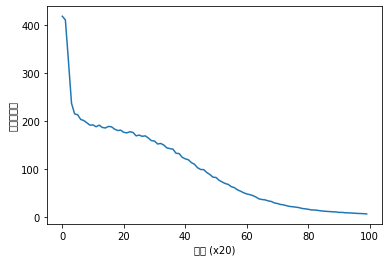

In [79]:
trainer.plot()

In [10]:
"""
| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.40
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 388.67
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 269.74
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 221.38
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 211.50
| 에폭 6 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 210.37
| 에폭 7 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 201.75
| 에폭 8 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 201.22
| 에폭 9 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 195.44
| 에폭 10 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 191.58
| 에폭 11 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 193.02
| 에폭 12 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 190.21
| 에폭 13 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 193.58
| 에폭 14 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 187.42
| 에폭 15 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 187.22
| 에폭 16 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 191.49
| 에폭 17 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 189.51
| 에폭 18 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 185.56
| 에폭 19 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 181.39
| 에폭 20 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 182.44
| 에폭 21 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 179.45
| 에폭 22 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 178.03
| 에폭 23 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 179.69
| 에폭 24 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 177.88
| 에폭 25 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 172.77
| 에폭 26 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 174.31
| 에폭 27 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 172.37
| 에폭 28 |  반복 1 / 19 | 시간 9[s] | 퍼플렉서티 171.74
| 에폭 29 |  반복 1 / 19 | 시간 9[s] | 퍼플렉서티 165.65
| 에폭 30 |  반복 1 / 19 | 시간 9[s] | 퍼플렉서티 162.83
| 에폭 31 |  반복 1 / 19 | 시간 10[s] | 퍼플렉서티 162.01
| 에폭 32 |  반복 1 / 19 | 시간 10[s] | 퍼플렉서티 157.29
| 에폭 33 |  반복 1 / 19 | 시간 10[s] | 퍼플렉서티 156.05
| 에폭 34 |  반복 1 / 19 | 시간 10[s] | 퍼플렉서티 155.94
| 에폭 35 |  반복 1 / 19 | 시간 11[s] | 퍼플렉서티 148.33
| 에폭 36 |  반복 1 / 19 | 시간 11[s] | 퍼플렉서티 145.93
| 에폭 37 |  반복 1 / 19 | 시간 11[s] | 퍼플렉서티 147.12
| 에폭 38 |  반복 1 / 19 | 시간 12[s] | 퍼플렉서티 137.58
| 에폭 39 |  반복 1 / 19 | 시간 12[s] | 퍼플렉서티 133.29
| 에폭 40 |  반복 1 / 19 | 시간 12[s] | 퍼플렉서티 129.35
| 에폭 41 |  반복 1 / 19 | 시간 12[s] | 퍼플렉서티 124.51
| 에폭 42 |  반복 1 / 19 | 시간 13[s] | 퍼플렉서티 124.36
| 에폭 43 |  반복 1 / 19 | 시간 13[s] | 퍼플렉서티 118.16
| 에폭 44 |  반복 1 / 19 | 시간 13[s] | 퍼플렉서티 113.97
| 에폭 45 |  반복 1 / 19 | 시간 14[s] | 퍼플렉서티 106.71
| 에폭 46 |  반복 1 / 19 | 시간 14[s] | 퍼플렉서티 103.94
| 에폭 47 |  반복 1 / 19 | 시간 14[s] | 퍼플렉서티 103.66
| 에폭 48 |  반복 1 / 19 | 시간 14[s] | 퍼플렉서티 97.71
| 에폭 49 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 92.86
| 에폭 50 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 88.03
| 에폭 51 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 85.11
| 에폭 52 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 81.13
| 에폭 53 |  반복 1 / 19 | 시간 15[s] | 퍼플렉서티 78.45
| 에폭 54 |  반복 1 / 19 | 시간 16[s] | 퍼플렉서티 74.04
| 에폭 55 |  반복 1 / 19 | 시간 16[s] | 퍼플렉서티 71.39
| 에폭 56 |  반복 1 / 19 | 시간 16[s] | 퍼플렉서티 67.06
| 에폭 57 |  반복 1 / 19 | 시간 16[s] | 퍼플렉서티 67.58
| 에폭 58 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 60.83
| 에폭 59 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 60.12
| 에폭 60 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 55.34
| 에폭 61 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 51.87
| 에폭 62 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 49.43
| 에폭 63 |  반복 1 / 19 | 시간 17[s] | 퍼플렉서티 49.02
| 에폭 64 |  반복 1 / 19 | 시간 18[s] | 퍼플렉서티 45.92
| 에폭 65 |  반복 1 / 19 | 시간 18[s] | 퍼플렉서티 41.99
| 에폭 66 |  반복 1 / 19 | 시간 18[s] | 퍼플렉서티 39.18
| 에폭 67 |  반복 1 / 19 | 시간 19[s] | 퍼플렉서티 37.11
| 에폭 68 |  반복 1 / 19 | 시간 19[s] | 퍼플렉서티 37.12
| 에폭 69 |  반복 1 / 19 | 시간 19[s] | 퍼플렉서티 34.00
| 에폭 70 |  반복 1 / 19 | 시간 19[s] | 퍼플렉서티 31.95
| 에폭 71 |  반복 1 / 19 | 시간 20[s] | 퍼플렉서티 29.78
| 에폭 72 |  반복 1 / 19 | 시간 21[s] | 퍼플렉서티 28.03
| 에폭 73 |  반복 1 / 19 | 시간 22[s] | 퍼플렉서티 27.81
| 에폭 74 |  반복 1 / 19 | 시간 23[s] | 퍼플렉서티 25.21
| 에폭 75 |  반복 1 / 19 | 시간 24[s] | 퍼플렉서티 24.42
| 에폭 76 |  반복 1 / 19 | 시간 25[s] | 퍼플렉서티 22.28
| 에폭 77 |  반복 1 / 19 | 시간 25[s] | 퍼플렉서티 21.84
| 에폭 78 |  반복 1 / 19 | 시간 27[s] | 퍼플렉서티 20.99
| 에폭 79 |  반복 1 / 19 | 시간 27[s] | 퍼플렉서티 18.94
| 에폭 80 |  반복 1 / 19 | 시간 27[s] | 퍼플렉서티 17.64
| 에폭 81 |  반복 1 / 19 | 시간 27[s] | 퍼플렉서티 16.60
| 에폭 82 |  반복 1 / 19 | 시간 28[s] | 퍼플렉서티 17.15
| 에폭 83 |  반복 1 / 19 | 시간 29[s] | 퍼플렉서티 16.31
| 에폭 84 |  반복 1 / 19 | 시간 29[s] | 퍼플렉서티 15.28
| 에폭 85 |  반복 1 / 19 | 시간 29[s] | 퍼플렉서티 13.64
| 에폭 86 |  반복 1 / 19 | 시간 29[s] | 퍼플렉서티 13.32
| 에폭 87 |  반복 1 / 19 | 시간 30[s] | 퍼플렉서티 12.73
| 에폭 88 |  반복 1 / 19 | 시간 30[s] | 퍼플렉서티 11.60
| 에폭 89 |  반복 1 / 19 | 시간 30[s] | 퍼플렉서티 11.32
| 에폭 90 |  반복 1 / 19 | 시간 31[s] | 퍼플렉서티 10.35
| 에폭 91 |  반복 1 / 19 | 시간 31[s] | 퍼플렉서티 10.10
| 에폭 92 |  반복 1 / 19 | 시간 32[s] | 퍼플렉서티 9.75
| 에폭 93 |  반복 1 / 19 | 시간 32[s] | 퍼플렉서티 9.44
| 에폭 94 |  반복 1 / 19 | 시간 32[s] | 퍼플렉서티 8.23
| 에폭 95 |  반복 1 / 19 | 시간 32[s] | 퍼플렉서티 7.90
| 에폭 96 |  반복 1 / 19 | 시간 33[s] | 퍼플렉서티 7.98
| 에폭 97 |  반복 1 / 19 | 시간 33[s] | 퍼플렉서티 7.10
| 에폭 98 |  반복 1 / 19 | 시간 33[s] | 퍼플렉서티 6.94
| 에폭 99 |  반복 1 / 19 | 시간 33[s] | 퍼플렉서티 6.79
| 에폭 100 |  반복 1 / 19 | 시간 34[s] | 퍼플렉서티 6.65
"""

'\n| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.40\n| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 388.67\n| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 269.74\n| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 221.38\n| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 211.50\n| 에폭 6 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 210.37\n| 에폭 7 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 201.75\n| 에폭 8 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 201.22\n| 에폭 9 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 195.44\n| 에폭 10 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 191.58\n| 에폭 11 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 193.02\n| 에폭 12 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 190.21\n| 에폭 13 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 193.58\n| 에폭 14 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 187.42\n| 에폭 15 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 187.22\n| 에폭 16 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 191.49\n| 에폭 17 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 189.51\n| 에폭 18 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 185.56\n| 에폭 19 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 181.39\n| 에폭 20 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 182.44\n| 에폭 21 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 179.45\n| 에폭 22 |  반복 1 / 1

# train_custom_loop.py

In [81]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
#from common.optimizer import SGD
from dataset import ptb
#from simple_rnnlm import SimpleRnnlm

In [82]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100
corpus_size = 1000

In [86]:
# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

말뭉치 크기: 1000, 어휘 수: 418


In [88]:
xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print("data_size:", data_size)

data_size: 999


### 학습 시 사용하는 변수

In [93]:
# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size) # 999 // (10*5) = 19.98
max_iters

19

In [92]:
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

In [144]:
# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

TimeEmbedding init W: (418, 100)


In [145]:
# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

In [146]:
for epoch in range(max_epoch): # 총 에폭수 
    for iter in range(max_iters): # 1 에폭에서 배치따른 총 반복수
        print("=========================={}번째 iter==========================".format(iter))
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i') # (10, 5)
        batch_t = np.empty((batch_size, time_size), dtype='i') # (10, 5)
        
        for t in range(time_size):
            print("----------------------{}번째 time_size----------------------".format(t))
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
                #print("batch_x[{}, {}]: {}".format(i, t, batch_x[i, t]))
                #print("batch_t[{}, {}]: {}".format(i, t, batch_t[i, t]))
            #print("batch_x[:, {}]: {}".format(t, batch_x[:, t]))
            #print("batch_t[:, {}]: {}".format(t, batch_t[:, t]))
            time_idx += 1

        print("batch_x[:, :]:\n", batch_x.shape)
        print("batch_x[:, :]:\n", batch_x)
        print("batch_t[:, :]:\n", batch_t.shape)
        print("batch_t[:, :]:\n", batch_t)
                
        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[337 338  24  32 339]
 [ 35 368 378  24 379]
 [ 27  27 169  27  27]
 [ 55  35  36  37  42]
 [112 113  83  79  80]
 [162 163  26  42 164]
 [197 198  24 199  42]
 [230  26 231  54 232]
 [ 42 122  24  79 241]
 [108 292  48  26 255]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[338  24  32 339 340]
 [368 378  24 379 369]
 [ 27 169  27  27  24]
 [ 35  36  37  42  56]
 [113  83  79  80  35]
 [163  26  42 164 119]
 [198  24 199  42  32]
 [ 26 231  54 232 233]
 [122  24  79 241  26]
 [292  48  26 255  48]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================10번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[358 181  35 114  24]
 [181  32 114  27 363]
 [ 18  19  20  21  22]
 [ 85  26  62  78  86]
 [ 42  61 137 138 139]
 [108  32 182 183  48]
 [214 148 215  26 202]
 [ 26  98  24  32 237]
 [ 24 133  27  76 160]
 [308 309  26 202  98]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[181  35 114  24 339]
 [ 32 114  27 363  24]
 [ 19  20  21  22  23]
 [ 26  62  78  86  32]
 [ 61 137 138 139 140]
 [ 32 182 183  48 184]
 [148 215  26 202  98]
 [ 98  24  32 237  40]
 [133  27  76 160  35]
 [309  26 202  98  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.8360748291015625
==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[368 378  24 379 369]
 [ 27 169  27  27  24]
 [ 35  36  37  42  56]
 [113  83  79  80  35]
 [163  26  42 164 119]
 [198  24 199  42  32]
 [ 26 231  54 232 233]
 [122  24  79 241  26]
 [292  48  26 255  48]
 [332  93 333 308 334]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[378  24 379 369 159]
 [169  27  27  24 409]
 [ 36  37  42  56  57]
 [ 83  79  80  35 

==========================14번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[325 396  26  95 397]
 [ 34  35  36  37  38]
 [ 94  95  96  97  82]
 [146  26 147  32  82]
 [ 27  64  27  27 187]
 [ 32  76 160  32 216]
 [ 35 209 252  42 253]
 [ 64  61 108  32 183]
 [ 24 315 316 154  64]
 [ 42  32 328 360 361]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[396  26  95 397 134]
 [ 35  36  37  38  27]
 [ 95  96  97  82  98]
 [ 26 147  32  82 148]
 [ 64  27  27 187  66]
 [ 76 160  32 216  26]
 [209 252  42 253 181]
 [ 61 108  32 183  24]
 [315 316 154  64 317]
 [ 32 328 360 361  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================10번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 10  11  12  13  14]
 [ 82  83  24  32  61]
 [131 132 133  28  81]
 [177 178 108 179 180]
 [210  40  35 211 212]
 [243 108 244 172  48]
 [278 276  42  26  61]
 [142 306  93 307  42]
 [181  32 351 352 353]
 [307  64 220  35 389]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 11  12  13  14  15]
 [ 83  24  32  61  84]
 [132 133  28  81 134]
 [178 108 179 180 181]
 [ 40  35 211 212  75]
 [108 244 172  48 245]
 [276  42  26  61  30]
 [306  93 307  42 213]
 [ 32 351 352 353  24]
 [ 64 220  35 389 390]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 61  62  63  64  65]
 [118 119 101 120 121]
 [ 35 168  42  82 169]
 [195  87 204  26  73]
 [ 24  32 212 234  30]
 [264 229  32 265 166]
 [295  63  64  65  68]
 [339 340 341 342  42]
 [379 369 159 380  35]
 [ 27  24 409 399 336]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 62  63  64  65  66]
 [119 101 120 121  42]
 [168  42  82 169  32]
 [ 87 204  26  73  24]
 [ 32 212 234  30 235]
 [229  32 265 166  26]
 [ 63  64  65  68  24]
 [340 341 342  42  32]
 [369 159 380  35 381]
 [ 24 409 399 336 108]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.46409912109375
==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26 108 109  26  67]
 [154 142 155 156 152]
 [ 87  32 193  27 154]
 [224 225  98  24  32]
 [ 26  35 260  42  26]
 [ 26  26  42  32 287]
 [324 118  24 325 152]
 [368 369 159 370  64]
 [108 401 337 338  24]
 [ 43  32  44  45  46]]
batch_t[:, :]:
 (10, 5)
batch_t[:, 

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.612320556640625
==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[127  24  35  26  26]
 [ 48 164 174  24  32]
 [ 48  26  54 208 209]
 [ 42  61 203  26  79]
 [272 273 152 274 275]
 [ 42  32 218  88 303]
 [348  35 349  42  35]
 [385  24  32 339 359]
 [414  42  32  27 343]
 [ 68  69  70  35  71]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 24  35  26  26  98]
 [164 174  24  32  26]
 [ 26  54 208 209  80]
 [ 61 203  26  79  

==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[162 163  26  42 164]
 [197 198  24 199  42]
 [230  26 231  54 232]
 [ 42 122  24  79 241]
 [108 292  48  26 255]
 [331 332  93 333 308]
 [375 333 308  64 376]
 [188 160 405 119 406]
 [ 48  49  41  42  50]
 [109  26  67  68 108]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[163  26  42 164 119]
 [198  24 199  42  32]
 [ 26 231  54 232 233]
 [122  24  79 241  26]
 [292  48  26 255  48]
 [332  93 333 308 334]
 [333 308  64 376 377]
 [160 405 119 406 181]
 [ 49  41  42  50  51]
 [ 26  67  68 108  27]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.17207275390625
==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 80 195 196  32 197]
 [ 40 228 229  26 230]
 [174  42 261 262  42]
 [ 35 290  26 291 108]
 [328 329  64 330 331]
 [337 338 373 374 375]
 [152 402 403 404 188]
 [ 26  27  28  29  48]
 [106 107  26 108 109]
 [ 24 130 154 142 155]]
batch_t[:, :]:
 (10, 5)
batch_t[:, 

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.230986938476563
==========================17번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42 207  73  74  75]
 [249  93 250 251 154]
 [ 32  66  68 113  77]
 [314 181  26 230  26]
 [ 35 114  24 339 359]
 [114  27 363  24 394]
 [ 20  21  22  23  24]
 [ 62  78  86  32  26]
 [137 138 139 140  24]
 [182 183  48 184  87]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[207  73  74  75  32]
 [ 93 250 251 154  35]
 [ 66  68 113  77  64]
 [181  26 230  26 

==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 30 235 213 148 236]
 [166  26 266  24 108]
 [ 68  24  76 296 297]
 [ 42  32  27 343 328]
 [ 35 381  42 382 338]
 [336 108 325 410 411]
 [ 59  24  35  60  42]
 [ 32 115 116 117 108]
 [165  24 166  26 167]
 [ 76 154  26 202 203]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[235 213 148 236  93]
 [ 26 266  24 108 267]
 [ 24  76 296 297  42]
 [ 32  27 343 328 344]
 [381  42 382 338 373]
 [108 325 410 411  64]
 [ 24  35  60  42  61]
 [115 116 117 108 118]
 [ 24 166  26 167  35]
 [154  26 202 203 195]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[259  26  35 260  42]
 [286  26  26  42  32]
 [323 324 118  24 325]
 [ 24 368 369 159 370]
 [400 108 401 337 338]
 [ 26  43  32  44  45]
 [101 102  26 103  93]
 [138 151 152 153  42]
 [ 32 189  98  24  75]
 [ 32 221 181 138  61]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26  35 260  42  26]
 [ 26  26  42  32 287]
 [324 118  24 325 152]
 [368 369 159 370  64]
 [108 401 337 338  24]
 [ 43  32  44  45  46]
 [102  26 103  93 104]
 [151 152 153  42  32]
 [189  98  24  75  27]
 [221 181 138  61  76]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.476637573242187
==========================17번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 76 160  35 218  93]
 [202  98  26 310 311]
 [356  48  93  32 357]
 [392 192 393  35  71]
 [ 12  13  14  15  16]
 [ 24  32  61  84  26]
 [133  28  81 134 135]
 [108 179 180 181  32]
 [ 35 211 212  75 213]
 [244 172  48 245 246]]
batch_t[:, :]:
 (10, 5)
batch_t[:

==========================11번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 76 296 297  42 298]
 [ 27 343 328 344 229]
 [ 42 382 338 373 333]
 [325 410 411  64 412]
 [ 35  60  42  61  62]
 [116 117 108 118 119]
 [166  26 167  35 168]
 [ 26 202 203 195  87]
 [ 32  67  68  24  32]
 [159  79 263 264 229]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[296 297  42 298 299]
 [343 328 344 229  26]
 [382 338 373 333 308]
 [410 411  64 412 413]
 [ 60  42  61  62  63]
 [117 108 118 119 101]
 [ 26 167  35 168  42]
 [202 203 195  87 204]
 [ 67  68  24  32 212]
 [ 79 263 264 229  32]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.260386962890625
==========================7번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[327 328 329  64 330]
 [372 337 338 373 374]
 [342 152 402 403 404]
 [ 47  26  27  28  29]
 [105 106 107  26 108]
 [105  24 130 154 142]
 [148 191 192  87  32]
 [108 222 223 224 225]
 [ 64  26 259  26  35]
 [ 76 285 286  26  26]]
batch_t[:, :]:
 (10, 5)
batch_t[:,

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.246868896484375
==========================2번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[359  42  32 328 360]
 [394  98  26  26  26]
 [ 24  25  26  27  28]
 [ 26  87  88  89  90]
 [ 24 141  40 142  61]
 [ 87  35 185 186  42]
 [166  26  24  32  72]
 [247  42  32 248 223]
 [218  93 280 180 181]
 [310 311 312  42 313]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 42  32 328 360 361]
 [ 98  26  26  26 395]
 [ 25  26  27  28  29]
 [ 87  88  89  90  

==========================13번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[338 373 333 308 383]
 [411  64 412 413 289]
 [ 42  61  62  63  64]
 [108 118 119 101 120]
 [167  35 168  42  82]
 [203 195  87 204  26]
 [ 68  24  32 212 234]
 [263 264 229  32 265]
 [ 35 295  63  64  65]
 [ 32 339 340 341 342]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[373 333 308 383 384]
 [ 64 412 413 289 345]
 [ 61  62  63  64  65]
 [118 119 101 120 121]
 [ 35 168  42  82 169]
 [195  87 204  26  73]
 [ 24  32 212 234  30]
 [264 229  32 265 166]
 [295  63  64  65  68]
 [339 340 341 342  42]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 35  71 350 181  32]
 [ 15  16  17  18  19]
 [ 84  26  40  85  26]
 [134 135 136  42  61]
 [181  32  68 108  32]
 [ 75 213  42 214 148]
 [245 246 166  26  98]
 [ 30 220 279  24 133]
 [213  76  48 308 309]
 [ 24 341 325 354 355]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 71 350 181  32 114]
 [ 16  17  18  19  20]
 [ 26  40  85  26  62]
 [135 136  42  61 137]
 [ 32  68 108  32 182]
 [213  42 214 148 215]
 [246 166  26  98  24]
 [220 279  24 133  27]
 [ 76  48 308 309  26]
 [341 325 354 355  42]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 27  27  24 409 399]
 [ 37  42  56  57  58]
 [ 79  80  35 114  81]
 [ 42 164 119  26  73]
 [199  42  32 200 201]
 [ 54 232 233  87  26]
 [ 79 241  26 255 159]
 [ 26 255  48  26 293]
 [333 308 334 335 336]
 [ 64 376 377 209 338]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 27  24 409 399 336]
 [ 42  56  57  58  59]
 [ 80  35 114  81  32]
 [164 119  26  73 165]
 [ 42  32 200 201  76]
 [232 233  87  26  64]
 [241  26 255 159  26]
 [255  48  26 293  32]
 [308 334 335 336 108]
 [376 377 209 338 181]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.38409423828125
==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 46  24  47  26  27]
 [104  66 105 106 107]
 [ 32  66 105  24 130]
 [ 27 190 148 191 192]
 [ 76 149 108 222 223]
 [ 26 258  64  26 259]
 [ 63  24  76 285 286]
 [142 322 152 143 323]
 [258  64 367 119  24]
 [398 373  42 399 400]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 24  47  26  27  28]
 [ 66 105 106 107  26]
 [ 66 105  24 130 154]
 [190 148 191 192  87]
 [149 108 222 223 224]
 [258  64  26 259  26]
 [ 24  76 285 286  26]
 [322 152 143 323 324]
 [

==========================3번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 40  85  26  62  78]
 [136  42  61 137 138]
 [ 68 108  32 182 183]
 [ 42 214 148 215  26]
 [166  26  98  24  32]
 [279  24 133  27  76]
 [ 48 308 309  26 202]
 [325 354 355  42 356]
 [213 308 391  32 392]
 [  8   9  10  11  12]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 85  26  62  78  86]
 [ 42  61 137 138 139]
 [108  32 182 183  48]
 [214 148 215  26 202]
 [ 26  98  24  32 237]
 [ 24 133  27  76 160]
 [308 309  26 202  98]
 [354 355  42 356  48]
 [308 391  32 392 192]
 [  9  10  11  12  13]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.213030395507812
| 에폭 15 | 퍼플렉서티 189.31
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 24  35  26  26  98]
 [164 174  24  32  26]
 [ 26  54 208 209  80]
 [ 61 203  26  79  26]
 [273 152 274 275 276]
 [ 32 218  88 303  26]
 [ 35 349  42  35  72]
 [ 24  32 339 359 181]
 [ 42  32  27 343 328]
 [ 69  70  35  71  72]]
batch_t[:, 

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.109577026367187
==========================15번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26  73 165  24 166]
 [200 201  76 154  26]
 [ 87  26  64  65  32]
 [255 159  26  48 159]
 [ 26 293  32 294 255]
 [335 336 108 337 338]
 [209 338 181  35 368]
 [407 408  64  27  27]
 [ 52  53  54  55  35]
 [ 24 110 111 112 113]]
batch_t[:, :]:
 (10, 5)
batch_t[:

==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 27  64  27  27 187]
 [ 32  76 160  32 216]
 [ 35 209 252  42 253]
 [ 64  61 108  32 183]
 [ 24 315 316 154  64]
 [ 42  32 328 360 361]
 [ 98  26  26  26 395]
 [ 25  26  27  28  29]
 [ 87  88  89  90  64]
 [141  40 142  61 108]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 64  27  27 187  66]
 [ 76 160  32 216  26]
 [209 252  42 253 181]
 [ 61 108  32 183  24]
 [315 316 154  64 317]
 [ 32 328 360 361  26]
 [ 26  26  26 395  42]
 [ 26  27  28  29  30]
 [ 88  89  90  64  78]
 [ 40 142  61 108 143]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================17번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[203 195  87 204  26]
 [ 68  24  32 212 234]
 [263 264 229  32 265]
 [ 35 295  63  64  65]
 [ 32 339 340 341 342]
 [ 24 379 369 159 380]
 [ 27  27  24 409 399]
 [ 37  42  56  57  58]
 [ 79  80  35 114  81]
 [ 42 164 119  26  73]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[195  87 204  26  73]
 [ 24  32 212 234  30]
 [264 229  32 265 166]
 [295  63  64  65  68]
 [339 340 341 342  42]
 [379 369 159 380  35]
 [ 27  24 409 399 336]
 [ 42  56  57  58  59]
 [ 80  35 114  81  32]
 [164 119  26  73 165]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.333781127929687
==========================11번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[220  32 221 181 138]
 [ 34  26  93 159 257]
 [282 283 284  32  26]
 [ 27  28  81  24  78]
 [363  32 364 365 182]
 [ 26  95 397 134 374]
 [ 36  37  38  27  24]
 [ 96  97  82  98  24]
 [147  32  82 148 149]
 [ 27  27 187  66 105]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 32 221 181 138  61]
 [ 26  93 159 257  34]
 [283 284  32  26  54]
 [ 28  81  24  78 

output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.8230068969726565
==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[108 244 172  48 245]
 [276  42  26  61  30]
 [306  93 307  42 213]
 [ 32 351 352 353  24]
 [ 64 220  35 389 390]
 [  2   3   4   5   6]
 [ 77  64  78  79  80]
 [ 98  56  40 128  29]
 [ 26 175  98  61  54]
 [ 80 197  32  82  98]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[244 172  48 245 246]
 [ 42  26  61  30 220]
 [ 93 307  42 213  76]
 [351 352 353  24 341]
 [220  35 389 390 373]
 [  3   4   5   6   7]
 [ 64  78  79  80  27]
 [ 56  40 128  29 129]


output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.3540277099609375
==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 48 159  79 263 264]
 [294 255 108  35 295]
 [337 338  24  32 339]
 [ 35 368 378  24 379]
 [ 27  27 169  27  27]
 [ 55  35  36  37  42]
 [112 113  83  79  80]
 [162 163  26  42 164]
 [197 198  24 199  42]
 [230  26 231  54 232]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[159  79 263 264 229]
 [255 108  35 295  63]
 [338  24  32 339 340]
 [368 378  24 379

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.261588134765625
==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32 218 113 282 283]
 [319 320 321  27  28]
 [362  64  27 363  32]
 [347 325 396  26  95]
 [ 33  34  35  36  37]
 [ 93  94  95  96  97]
 [ 24 146  26 147  32]
 [169  27  64  27  27]
 [ 75  32  76 160  32]
 [154  35 209 252  42]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[218 113 282 283 284]
 [320 321  27  28  81]
 [ 64  27 363  32 364]
 [325 396  26  95 

output: 4.8493478393554685
==========================7번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[307  42 213  76  48]
 [352 353  24 341 325]
 [ 35 389 390 373 213]
 [  4   5   6   7   8]
 [ 78  79  80  27  28]
 [ 40 128  29 129  24]
 [ 98  61  54  63 108]
 [ 32  82  98  24  32]
 [ 32 241 242  42  61]
 [ 61  24 229  27 277]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 42 213  76  48 308]
 [353  24 341 325 354]
 [389 390 373 213 308]
 [  5   6   7   8   9]
 [ 79  80  27  28  81]
 [128  29 129  24 130]
 [ 61  54  63 108 176]
 [ 82  98  24  32  26]
 [241 242  42  61  26]
 [ 24 229  27 277 275]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output

| 에폭 21 | 퍼플렉서티 176.46
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[335 336 108 337 338]
 [209 338 181  35 368]
 [407 408  64  27  27]
 [ 52  53  54  55  35]
 [ 24 110 111 112 113]
 [160 161  98 162 163]
 [195 196  32 197 198]
 [228 229  26 230  26]
 [ 42 261 262  42 122]
 [290  26 291 108 292]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[336 108 337 338  24]
 [338 181  35 368 378]
 [408  64  27  27 169]
 [ 53  54  55  35  36]
 [110 111 112 113  83]
 [161  98 162 163  26]
 [196  32 197 198  24]
 [229  26 230  26 231]
 [261 262  42 122  24]
 [ 26 291 108 292  48]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (1

output: 5.15680908203125
==========================15번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[182 366 258  64 367]
 [374  26 398 373  42]
 [ 24  39  26  40  41]
 [ 24  26  99  32 100]
 [149  32  76 113 150]
 [105  87  32  68 113]
 [217 180 218 219  64]
 [ 32 254  26 255 256]
 [281  42  32 218 113]
 [ 93 318 319 320 321]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[366 258  64 367 119]
 [ 26 398 373  42 399]
 [ 39  26  40  41  42]
 [ 26  99  32 100  42]
 [ 32  76 113 150  42]
 [ 87  32  68 113 188]
 [180 218 219  64 220]
 [254  26 255 256  34]
 [ 42  32 218 113 282]
 [318 319 320 321  27]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output:

==========================10번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32 392 192 393  35]
 [ 11  12  13  14  15]
 [ 83  24  32  61  84]
 [132 133  28  81 134]
 [178 108 179 180 181]
 [ 40  35 211 212  75]
 [108 244 172  48 245]
 [276  42  26  61  30]
 [306  93 307  42 213]
 [ 32 351 352 353  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[392 192 393  35  71]
 [ 12  13  14  15  16]
 [ 24  32  61  84  26]
 [133  28  81 134 135]
 [108 179 180 181  32]
 [ 35 211 212  75 213]
 [244 172  48 245 246]
 [ 42  26  61  30 220]
 [ 93 307  42 213  76]
 [351 352 353  24 341]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

| 에폭 23 | 퍼플렉서티 173.57
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[403 404 188 160 405]
 [ 28  29  48  49  41]
 [ 26 108 109  26  67]
 [154 142 155 156 152]
 [ 87  32 193  27 154]
 [224 225  98  24  32]
 [ 26  35 260  42  26]
 [ 26  26  42  32 287]
 [324 118  24 325 152]
 [368 369 159 370  64]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[404 188 160 405 119]
 [ 29  48  49  41  42]
 [108 109  26  67  68]
 [142 155 156 152 157]
 [ 32 193  27 154 194]
 [225  98  24  32 226]
 [ 35 260  42  26 160]
 [ 26  42  32 287 288]
 [118  24 325 152 326]
 [369 159 370  64 371]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (1

==========================15번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32  33  34  35  36]
 [ 92  93  94  95  96]
 [145  24 146  26 147]
 [ 24 169  27  64  27]
 [ 74  75  32  76 160]
 [251 154  35 209 252]
 [113  77  64  61 108]
 [230  26  24 315 316]
 [339 359  42  32 328]
 [ 24 394  98  26  26]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 33  34  35  36  37]
 [ 93  94  95  96  97]
 [ 24 146  26 147  32]
 [169  27  64  27  27]
 [ 75  32  76 160  32]
 [154  35 209 252  42]
 [ 77  64  61 108  32]
 [ 26  24 315 316 154]
 [359  42  32 328 360]
 [394  98  26  26  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.327662353515625
==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32  61  84  26  40]
 [ 28  81 134 135 136]
 [179 180 181  32  68]
 [211 212  75 213  42]
 [172  48 245 246 166]
 [ 26  61  30 220 279]
 [307  42 213  76  48]
 [352 353  24 341 325]
 [ 35 389 390 373 213]
 [  4   5   6   7   8]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 61  84  26  40  85]
 [ 81 134 135 136  42]
 [180 181  32  68 108]
 [212  75 213  42 

==========================7번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[120 121  42 122  35]
 [ 82 169  32 170  73]
 [ 26  73  24  32 205]
 [234  30 235 213 148]
 [265 166  26 266  24]
 [ 65  68  24  76 296]
 [342  42  32  27 343]
 [380  35 381  42 382]
 [399 336 108 325 410]
 [ 58  59  24  35  60]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[121  42 122  35 123]
 [169  32 170  73 165]
 [ 73  24  32 205  42]
 [ 30 235 213 148 236]
 [166  26 266  24 108]
 [ 68  24  76 296 297]
 [ 42  32  27 343 328]
 [ 35 381  42 382 338]
 [336 108 325 410 411]
 [ 59  24  35  60  42]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================3번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[156 152 157 158 159]
 [ 27 154 194  79  80]
 [ 24  32 226 227  40]
 [ 42  26 160  32 174]
 [ 32 287 288 289  35]
 [325 152 326 327 328]
 [370  64 371 372 337]
 [338  24  32 342 152]
 [ 45  46  24  47  26]
 [ 93 104  66 105 106]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[152 157 158 159 160]
 [154 194  79  80 195]
 [ 32 226 227  40 228]
 [ 26 160  32 174  42]
 [287 288 289  35 290]
 [152 326 327 328 329]
 [ 64 371 372 337 338]
 [ 24  32 342 152 402]
 [ 46  24  47  26  27]
 [104  66 105 106 107]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 64  27  27 187  66]
 [ 76 160  32 216  26]
 [209 252  42 253 181]
 [ 61 108  32 183  24]
 [315 316 154  64 317]
 [ 32 328 360 361  26]
 [ 26  26  26 395  42]
 [ 26  27  28  29  30]
 [ 88  89  90  64  78]
 [ 40 142  61 108 143]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 27  27 187  66 105]
 [160  32 216  26 217]
 [252  42 253 181  32]
 [108  32 183  24 281]
 [316 154  64 317  93]
 [328 360 361  26 229]
 [ 26  26 395  42 345]
 [ 27  28  29  30  31]
 [ 89  90  64  78  91]
 [142  61 108 143 144]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: 4.556526489257813
==========================14번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 40  35 211 212  75]
 [108 244 172  48 245]
 [276  42  26  61  30]
 [306  93 307  42 213]
 [ 32 351 352 353  24]
 [ 64 220  35 389 390]
 [  2   3   4   5   6]
 [ 77  64  78  79  80]
 [ 98  56  40 128  29]
 [ 26 175  98  61  54]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 35 211 212  75 213]
 [244 172  48 245 246]
 [ 42  26  61  30 220]
 [ 93 307  42 213  76]
 [351 352 353  24 341]
 [220  35 389 390 373]
 [  3   4   5   6   7]
 [ 64  78  79  80  27]
 [ 56  40 128  29 129]
 [175  98  61  54  63]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output

==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32 212 234  30 235]
 [229  32 265 166  26]
 [ 63  64  65  68  24]
 [340 341 342  42  32]
 [369 159 380  35 381]
 [ 24 409 399 336 108]
 [ 56  57  58  59  24]
 [ 35 114  81  32 115]
 [119  26  73 165  24]
 [ 32 200 201  76 154]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[212 234  30 235 213]
 [ 32 265 166  26 266]
 [ 64  65  68  24  76]
 [341 342  42  32  27]
 [159 380  35 381  42]
 [409 399 336 108 325]
 [ 57  58  59  24  35]
 [114  81  32 115 116]
 [ 26  73 165  24 166]
 [200 201  76 154  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 35 260  42  26 160]
 [ 26  42  32 287 288]
 [118  24 325 152 326]
 [369 159 370  64 371]
 [401 337 338  24  32]
 [ 32  44  45  46  24]
 [ 26 103  93 104  66]
 [152 153  42  32  66]
 [ 98  24  75  27 190]
 [181 138  61  76 149]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[260  42  26 160  32]
 [ 42  32 287 288 289]
 [ 24 325 152 326 327]
 [159 370  64 371 372]
 [337 338  24  32 342]
 [ 44  45  46  24  47]
 [103  93 104  66 105]
 [153  42  32  66 105]
 [ 24  75  27 190 148]
 [138  61  76 149 108]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================14번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42  61  24 229  27]
 [304  26  32 305  24]
 [350  64  27  27 169]
 [328 386 387  64 388]
 [415 229 416  27 187]
 [ 42  73  74  75  35]
 [126  64  32 127  24]
 [ 42 173 174  48 164]
 [ 26 207  73  48  26]
 [239  32 240  42  61]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 61  24 229  27 277]
 [ 26  32 305  24 141]
 [ 64  27  27 169  27]
 [386 387  64 388 380]
 [229 416  27 187 417]
 [ 73  74  75  35  46]
 [ 64  32 127  24  35]
 [173 174  48 164 174]
 [207  73  48  26  54]
 [ 32 240  42  61 203]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.0369741821289065
==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32  26  54  63  24]
 [ 24  78  69 142 322]
 [365 182 366 258  64]
 [134 374  26 398 373]
 [ 27  24  39  26  40]
 [ 98  24  26  99  32]
 [148 149  32  76 113]
 [ 66 105  87  32  68]
 [ 26 217 180 218 219]
 [181  32 254  26 255]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26  54  63  24  76]
 [ 78  69 142 322 152]
 [182 366 258  64 367]
 [374  26 398 373 

==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[309  26 202  98  26]
 [355  42 356  48  93]
 [391  32 392 192 393]
 [ 10  11  12  13  14]
 [ 82  83  24  32  61]
 [131 132 133  28  81]
 [177 178 108 179 180]
 [210  40  35 211 212]
 [243 108 244 172  48]
 [278 276  42  26  61]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26 202  98  26 310]
 [ 42 356  48  93  32]
 [ 32 392 192 393  35]
 [ 11  12  13  14  15]
 [ 83  24  32  61  84]
 [132 133  28  81 134]
 [178 108 179 180 181]
 [ 40  35 211 212  75]
 [108 244 172  48 245]
 [276  42  26  61  30]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[329  64 330 331 332]
 [338 373 374 375 333]
 [402 403 404 188 160]
 [ 27  28  29  48  49]
 [107  26 108 109  26]
 [130 154 142 155 156]
 [192  87  32 193  27]
 [223 224 225  98  24]
 [259  26  35 260  42]
 [286  26  26  42  32]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 64 330 331 332  93]
 [373 374 375 333 308]
 [403 404 188 160 405]
 [ 28  29  48  49  41]
 [ 26 108 109  26  67]
 [154 142 155 156 152]
 [ 87  32 193  27 154]
 [224 225  98  24  32]
 [ 26  35 260  42  26]
 [ 26  26  42  32 287]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: 5.463670043945313
==========================16번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 27  27 169  27  27]
 [387  64 388 380 229]
 [416  27 187 417   0]
 [ 74  75  35  46  42]
 [ 32 127  24  35  26]
 [174  48 164 174  24]
 [ 73  48  26  54 208]
 [240  42  61 203  26]
 [ 35 272 273 152 274]
 [302  42  32 218  88]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 27 169  27  27 181]
 [ 64 388 380 229 307]
 [ 27 187 417  32   1]
 [ 75  35  46  42  76]
 [127  24  35  26  26]
 [ 48 164 174  24  32]
 [ 48  26  54 208 209]
 [ 42  61 203  26  79]
 [272 273 152 274 275]
 [ 42  32 218  88 303]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output

output: 4.910919189453125
==========================10번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 64 376 377 209 338]
 [119 406 181 407 408]
 [ 42  50  51  52  53]
 [ 68 108  27  24 110]
 [157 158 159 160 161]
 [194  79  80 195 196]
 [226 227  40 228 229]
 [160  32 174  42 261]
 [288 289  35 290  26]
 [326 327 328 329  64]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[376 377 209 338 181]
 [406 181 407 408  64]
 [ 50  51  52  53  54]
 [108  27  24 110 111]
 [158 159 160 161  98]
 [ 79  80 195 196  32]
 [227  40 228 229  26]
 [ 32 174  42 261 262]
 [289  35 290  26 291]
 [327 328 329  64 330]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output

output: 4.708456420898438
==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26  26 395  42 345]
 [ 27  28  29  30  31]
 [ 89  90  64  78  91]
 [142  61 108 143 144]
 [186  42  26 108  27]
 [ 32  72  42 207  73]
 [248 223 249  93 250]
 [180 181  32  66  68]
 [ 42 313 314 181  26]
 [358 181  35 114  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26 395  42 345 346]
 [ 28  29  30  31  32]
 [ 90  64  78  91  92]
 [ 61 108 143 144 145]
 [ 42  26 108  27  24]
 [ 72  42 207  73  74]
 [223 249  93 250 251]
 [181  32  66  68 113]
 [313 314 181  26 230]
 [181  35 114  24 339]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output:

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.99481201171875
==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[187 417   0   1   2]
 [ 35  46  42  76  77]
 [ 24  35  26  26  98]
 [164 174  24  32  26]
 [ 26  54 208 209  80]
 [ 61 203  26  79  26]
 [273 152 274 275 276]
 [ 32 218  88 303  26]
 [ 35 349  42  35  72]
 [ 24  32 339 359 181]]
batch_t[:, :]:
 (10, 5)
batch_t[:,

----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 28  29  30  31  32]
 [ 90  64  78  91  92]
 [ 61 108 143 144 145]
 [ 42  26 108  27  24]
 [ 72  42 207  73  74]
 [223 249  93 250 251]
 [181  32  66  68 113]
 [313 314 181  26 230]
 [181  35 114  24 339]
 [ 32 114  27 363  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 29  30  31  32  33]
 [ 64  78  91  92  93]
 [108 143 144 145  24]
 [ 26 108  27  24 169]
 [ 42 207  73  74  75]
 [249  93 250 251 154]
 [ 32  66  68 113  77]
 [314 181  26 230  26]
 [ 35 114  24 339 359]
 [114  27 363  24 394]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-----

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.45528076171875
==========================13번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 35  36  37  42  56]
 [113  83  79  80  35]
 [163  26  42 164 119]
 [198  24 199  42  32]
 [ 26 231  54 232 233]
 [122  24  79 241  26]
 [292  48  26 255  48]
 [332  93 333 308 334]
 [333 308  64 376 377]
 [160 405 119 406 181]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 36  37  42  56  57]
 [ 83  79  80  35 114]
 [ 26  42 164 119  26]
 [ 24 199  42  32 2

==========================2번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 81  82  83  24  32]
 [130 131 132 133  28]
 [176 177 178 108 179]
 [ 26 210  40  35 211]
 [ 26 243 108 244 172]
 [275 278 276  42  26]
 [119 142 306  93 307]
 [ 27 181  32 351 352]
 [229 307  64 220  35]
 [  0   1   2   3   4]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 82  83  24  32  61]
 [131 132 133  28  81]
 [177 178 108 179 180]
 [210  40  35 211 212]
 [243 108 244 172  48]
 [278 276  42  26  61]
 [142 306  93 307  42]
 [181  32 351 352 353]
 [307  64 220  35 389]
 [  1   2   3   4   5]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26  26  98  56  40]
 [ 24  32  26 175  98]
 [208 209  80 197  32]
 [ 26  79  26  80  32]
 [274 275 276  42  61]
 [ 88 303  26 304  26]
 [ 42  35  72 350  64]
 [339 359 181 328 386]
 [ 27 343 328 415 229]
 [ 35  71  72  42  73]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26  98  56  40 128]
 [ 32  26 175  98  61]
 [209  80 197  32  82]
 [ 79  26  80  32 241]
 [275 276  42  61  24]
 [303  26 304  26  32]
 [ 35  72 350  64  27]
 [359 181 328 386 387]
 [343 328 415 229 416]
 [ 71  72  42  73  74]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================10번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42 138 151 152 153]
 [188  32 189  98  24]
 [220  32 221 181 138]
 [ 34  26  93 159 257]
 [282 283 284  32  26]
 [ 27  28  81  24  78]
 [363  32 364 365 182]
 [ 26  95 397 134 374]
 [ 36  37  38  27  24]
 [ 96  97  82  98  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[138 151 152 153  42]
 [ 32 189  98  24  75]
 [ 32 221 181 138  61]
 [ 26  93 159 257  34]
 [283 284  32  26  54]
 [ 28  81  24  78  69]
 [ 32 364 365 182 366]
 [ 95 397 134 374  26]
 [ 37  38  27  24  39]
 [ 97  82  98  24  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.589797668457031
==========================17번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 35 168  42  82 169]
 [195  87 204  26  73]
 [ 24  32 212 234  30]
 [264 229  32 265 166]
 [295  63  64  65  68]
 [339 340 341 342  42]
 [379 369 159 380  35]
 [ 27  24 409 399 336]
 [ 42  56  57  58  59]
 [ 80  35 114  81  32]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[168  42  82 169  32]
 [ 87 204  26  73  24]
 [ 32 212 234  30 235]
 [229  32 265 166 

==========================11번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32 189  98  24  75]
 [ 32 221 181 138  61]
 [ 26  93 159 257  34]
 [283 284  32  26  54]
 [ 28  81  24  78  69]
 [ 32 364 365 182 366]
 [ 95 397 134 374  26]
 [ 37  38  27  24  39]
 [ 97  82  98  24  26]
 [ 32  82 148 149  32]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[189  98  24  75  27]
 [221 181 138  61  76]
 [ 93 159 257  34  26]
 [284  32  26  54  63]
 [ 81  24  78  69 142]
 [364 365 182 366 258]
 [397 134 374  26 398]
 [ 38  27  24  39  26]
 [ 82  98  24  26  99]
 [ 82 148 149  32  76]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.682711181640625
| 에폭 38 | 퍼플렉서티 123.73
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32 205  42  27  74]
 [213 148 236  93  32]
 [266  24 108 267  32]
 [ 76 296 297  42 298]
 [ 27 343 328 344 229]
 [ 42 382 338 373 333]
 [325 410 411  64 412]
 [ 35  60  42  61  62]
 [116 117 108 118 119]
 [166  26 167  35 168]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[205  42  27  74 169]
 [148 236  93  32 237]
 [ 24 108 267  32 2

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 5.117037963867188
==========================7번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[202  98 166  26  24]
 [237  40 247  42  32]
 [160  35 218  93 280]
 [ 98  26 310 311 312]
 [ 48  93  32 357 342]
 [192 393  35  71 350]
 [ 13  14  15  16  17]
 [ 32  61  84  26  40]
 [ 28  81 134 135 136]
 [179 180 181  32  68]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 98 166  26  24  32]
 [ 40 247  42  32 248]
 [ 35 218  93 280 180]
 [ 26 310 311 312  

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.8711474609375
==========================2번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[238 239  32 240  42]
 [269 270 271  35 272]
 [ 93 300 301 302  42]
 [119 345 346 347 348]
 [383 384 209 338 385]
 [289 345 328  24 414]
 [ 64  65  66  67  68]
 [120 121  42 122  35]
 [ 82 169  32 170  73]
 [ 26  73  24  32 205]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.2216317749023435
==========================11번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[253 181  32 254  26]
 [183  24 281  42  32]
 [ 64 317  93 318 319]
 [361  26 229  35 362]
 [395  42 345 346 347]
 [ 29  30  31  32  33]
 [ 64  78  91  92  93]
 [108 143 144 145  24]
 [ 26 108  27  24 169]
 [ 42 207  73  74  75]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[181  32 254  26 255]
 [ 24 281  42  32 218]
 [317  93 318 319 320]
 [ 26 229  35 362

==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[152 274 275 276  42]
 [218  88 303  26 304]
 [349  42  35  72 350]
 [ 32 339 359 181 328]
 [ 32  27 343 328 415]
 [ 70  35  71  72  42]
 [124  64 125 101 126]
 [ 48  32 171 172  42]
 [ 27  74 169 206  26]
 [ 93  32 237 238 239]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[274 275 276  42  61]
 [ 88 303  26 304  26]
 [ 42  35  72 350  64]
 [339 359 181 328 386]
 [ 27 343 328 415 229]
 [ 35  71  72  42  73]
 [ 64 125 101 126  64]
 [ 32 171 172  42 173]
 [ 74 169 206  26 207]
 [ 32 237 238 239  32]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.683179321289063
==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 48  26 255  48  26]
 [ 93 333 308 334 335]
 [308  64 376 377 209]
 [405 119 406 181 407]
 [ 41  42  50  51  52]
 [ 67  68 108  27  24]
 [152 157 158 159 160]
 [154 194  79  80 195]
 [ 32 226 227  40 228]
 [ 26 160  32 174  42]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26 255  48  26 293]
 [333 308 334 335 336]
 [ 64 376 377 209 338]
 [119 406 181 407 

==========================10번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[311 312  42 313 314]
 [357 342 358 181  35]
 [ 71 350 181  32 114]
 [ 16  17  18  19  20]
 [ 26  40  85  26  62]
 [135 136  42  61 137]
 [ 32  68 108  32 182]
 [213  42 214 148 215]
 [246 166  26  98  24]
 [220 279  24 133  27]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[312  42 313 314 181]
 [342 358 181  35 114]
 [350 181  32 114  27]
 [ 17  18  19  20  21]
 [ 40  85  26  62  78]
 [136  42  61 137 138]
 [ 68 108  32 182 183]
 [ 42 214 148 215  26]
 [166  26  98  24  32]
 [279  24 133  27  76]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[229  26 119 345 346]
 [333 308 383 384 209]
 [412 413 289 345 328]
 [ 62  63  64  65  66]
 [119 101 120 121  42]
 [168  42  82 169  32]
 [ 87 204  26  73  24]
 [ 32 212 234  30 235]
 [229  32 265 166  26]
 [ 63  64  65  68  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26 119 345 346 347]
 [308 383 384 209 338]
 [413 289 345 328  24]
 [ 63  64  65  66  67]
 [101 120 121  42 122]
 [ 42  82 169  32 170]
 [204  26  73  24  32]
 [212 234  30 235 213]
 [ 32 265 166  26 266]
 [ 64  65  68  24  76]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[371 372 337 338 373]
 [ 32 342 152 402 403]
 [ 24  47  26  27  28]
 [ 66 105 106 107  26]
 [ 66 105  24 130 154]
 [190 148 191 192  87]
 [149 108 222 223 224]
 [258  64  26 259  26]
 [ 24  76 285 286  26]
 [322 152 143 323 324]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[372 337 338 373 374]
 [342 152 402 403 404]
 [ 47  26  27  28  29]
 [105 106 107  26 108]
 [105  24 130 154 142]
 [148 191 192  87  32]
 [108 222 223 224 225]
 [ 64  26 259  26  35]
 [ 76 285 286  26  26]
 [152 143 323 324 118]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================6번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[385  24  32 339 359]
 [414  42  32  27 343]
 [ 68  69  70  35  71]
 [ 35 123 124  64 125]
 [ 73 165  48  32 171]
 [205  42  27  74 169]
 [148 236  93  32 237]
 [ 24 108 267  32 268]
 [296 297  42 298 299]
 [343 328 344 229  26]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 24  32 339 359 181]
 [ 42  32  27 343 328]
 [ 69  70  35  71  72]
 [123 124  64 125 101]
 [165  48  32 171 172]
 [ 42  27  74 169 206]
 [236  93  32 237 238]
 [108 267  32 268 269]
 [297  42 298 299  93]
 [328 344 229  26 119]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.568855590820313
==========================2번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[181 407 408  64  27]
 [ 51  52  53  54  55]
 [ 27  24 110 111 112]
 [159 160 161  98 162]
 [ 80 195 196  32 197]
 [ 40 228 229  26 230]
 [174  42 261 262  42]
 [ 35 290  26 291 108]
 [328 329  64 330 331]
 [337 338 373 374 375]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[407 408  64  27  27]
 [ 52  53  54  55  35]
 [ 24 110 111 112 113]
 [160 161  98 162 163]
 [195 196  32 197 198]
 [228 229  26 230  26]
 [ 42 261 262  42 122]
 [290  26 291 108 292]
 

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.4138662719726565
==========================11번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[  9  10  11  12  13]
 [ 81  82  83  24  32]
 [130 131 132 133  28]
 [176 177 178 108 179]
 [ 26 210  40  35 211]
 [ 26 243 108 244 172]
 [275 278 276  42  26]
 [119 142 306  93 307]
 [ 27 181  32 351 352]
 [229 307  64 220  35]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 10  11  12  13  14]
 [ 82  83  24  32  61]
 [131 132 133  28  81]
 [177 178 108 179

| 에폭 45 | 퍼플렉서티 90.35
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 44  45  46  24  47]
 [103  93 104  66 105]
 [153  42  32  66 105]
 [ 24  75  27 190 148]
 [138  61  76 149 108]
 [257  34  26 258  64]
 [ 26  54  63  24  76]
 [ 78  69 142 322 152]
 [182 366 258  64 367]
 [374  26 398 373  42]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 45  46  24  47  26]
 [ 93 104  66 105 106]
 [ 42  32  66 105  24]
 [ 75  27 190 148 191]
 [ 61  76 149 108 222]
 [ 34  26 258  64  26]
 [ 54  63  24  76 285]
 [ 69 142 322 152 143]
 [366 258  64 367 119]
 [ 26 398 373  42 399]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10

==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 73  74  75  35  46]
 [ 64  32 127  24  35]
 [173 174  48 164 174]
 [207  73  48  26  54]
 [ 32 240  42  61 203]
 [271  35 272 273 152]
 [301 302  42  32 218]
 [346 347 348  35 349]
 [209 338 385  24  32]
 [328  24 414  42  32]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 74  75  35  46  42]
 [ 32 127  24  35  26]
 [174  48 164 174  24]
 [ 73  48  26  54 208]
 [240  42  61 203  26]
 [ 35 272 273 152 274]
 [302  42  32 218  88]
 [347 348  35 349  42]
 [338 385  24  32 339]
 [ 24 414  42  32  27]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

| 에폭 46 | 퍼플렉서티 88.04
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42 101 102  26 103]
 [ 42 138 151 152 153]
 [188  32 189  98  24]
 [220  32 221 181 138]
 [ 34  26  93 159 257]
 [282 283 284  32  26]
 [ 27  28  81  24  78]
 [363  32 364 365 182]
 [ 26  95 397 134 374]
 [ 36  37  38  27  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[101 102  26 103  93]
 [138 151 152 153  42]
 [ 32 189  98  24  75]
 [ 32 221 181 138  61]
 [ 26  93 159 257  34]
 [283 284  32  26  54]
 [ 28  81  24  78  69]
 [ 32 364 365 182 366]
 [ 95 397 134 374  26]
 [ 37  38  27  24  39]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.548797607421875
==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42 122  35 123 124]
 [ 32 170  73 165  48]
 [ 24  32 205  42  27]
 [235 213 148 236  93]
 [ 26 266  24 108 267]
 [ 24  76 296 297  42]
 [ 32  27 343 328 344]
 [381  42 382 338 373]
 [108 325 410 411  64]
 [ 24  35  60  42  61]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[122  35 123 124  64]
 [170  73 165  48  32]
 [ 32 205  42  27  74]
 [213 148 236  93  

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.507461853027344
==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 98 162 163  26  42]
 [ 32 197 198  24 199]
 [ 26 230  26 231  54]
 [262  42 122  24  79]
 [291 108 292  48  26]
 [330 331 332  93 333]
 [374 375 333 308  64]
 [404 188 160 405 119]
 [ 29  48  49  41  42]
 [108 109  26  67  68]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[162 163  26  42 164]
 [197 198  24 199  42]
 [230  26 231  54 232]
 [ 42 122  24  79 2

==========================13번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 63 108 176 177 178]
 [ 24  32  26 210  40]
 [ 42  61  26 243 108]
 [ 27 277 275 278 276]
 [ 24 141 119 142 306]
 [169  27  27 181  32]
 [388 380 229 307  64]
 [187 417   0   1   2]
 [ 35  46  42  76  77]
 [ 24  35  26  26  98]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[108 176 177 178 108]
 [ 32  26 210  40  35]
 [ 61  26 243 108 244]
 [277 275 278 276  42]
 [141 119 142 306  93]
 [ 27  27 181  32 351]
 [380 229 307  64 220]
 [417  32   1   2   3]
 [ 46  42  76  77  64]
 [ 35  26  26  98  56]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 79  80 195 196  32]
 [227  40 228 229  26]
 [ 32 174  42 261 262]
 [289  35 290  26 291]
 [327 328 329  64 330]
 [372 337 338 373 374]
 [342 152 402 403 404]
 [ 47  26  27  28  29]
 [105 106 107  26 108]
 [105  24 130 154 142]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 80 195 196  32 197]
 [ 40 228 229  26 230]
 [174  42 261 262  42]
 [ 35 290  26 291 108]
 [328 329  64 330 331]
 [337 338 373 374 375]
 [152 402 403 404 188]
 [ 26  27  28  29  48]
 [106 107  26 108 109]
 [ 24 130 154 142 155]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.130557861328125
==========================15번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[211 212  75 213  42]
 [172  48 245 246 166]
 [ 26  61  30 220 279]
 [307  42 213  76  48]
 [352 353  24 341 325]
 [ 35 389 390 373 213]
 [  4   5   6   7   8]
 [ 78  79  80  27  28]
 [ 40 128  29 129  24]
 [ 98  61  54  63 108]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[212  75 213  42 214]
 [ 48 245 246 166  26]
 [ 61  30 220 279  24]
 [ 42 213  76  48 

==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 87  26  64  65  32]
 [255 159  26  48 159]
 [ 26 293  32 294 255]
 [335 336 108 337 338]
 [209 338 181  35 368]
 [407 408  64  27  27]
 [ 52  53  54  55  35]
 [ 24 110 111 112 113]
 [160 161  98 162 163]
 [195 196  32 197 198]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26  64  65  32  67]
 [159  26  48 159  79]
 [293  32 294 255 108]
 [336 108 337 338  24]
 [338 181  35 368 378]
 [408  64  27  27 169]
 [ 53  54  55  35  36]
 [110 111 112 113  83]
 [161  98 162 163  26]
 [196  32 197 198  24]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: 4.302271118164063
==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[247  42  32 248 223]
 [218  93 280 180 181]
 [310 311 312  42 313]
 [ 32 357 342 358 181]
 [ 35  71 350 181  32]
 [ 15  16  17  18  19]
 [ 84  26  40  85  26]
 [134 135 136  42  61]
 [181  32  68 108  32]
 [ 75 213  42 214 148]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 42  32 248 223 249]
 [ 93 280 180 181  32]
 [311 312  42 313 314]
 [357 342 358 181  35]
 [ 71 350 181  32 114]
 [ 16  17  18  19  20]
 [ 26  40  85  26  62]
 [135 136  42  61 137]
 [ 32  68 108  32 182]
 [213  42 214 148 215]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output

==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[159  26  48 159  79]
 [293  32 294 255 108]
 [336 108 337 338  24]
 [338 181  35 368 378]
 [408  64  27  27 169]
 [ 53  54  55  35  36]
 [110 111 112 113  83]
 [161  98 162 163  26]
 [196  32 197 198  24]
 [229  26 230  26 231]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26  48 159  79 263]
 [ 32 294 255 108  35]
 [108 337 338  24  32]
 [181  35 368 378  24]
 [ 64  27  27 169  27]
 [ 54  55  35  36  37]
 [111 112 113  83  79]
 [ 98 162 163  26  42]
 [ 32 197 198  24 199]
 [ 26 230  26 231  54]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 68 113  77  64  61]
 [ 26 230  26  24 315]
 [ 24 339 359  42  32]
 [363  24 394  98  26]
 [ 22  23  24  25  26]
 [ 86  32  26  87  88]
 [139 140  24 141  40]
 [ 48 184  87  35 185]
 [202  98 166  26  24]
 [237  40 247  42  32]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.879621887207031
==========================2번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
------------------

==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 24  76 296 297  42]
 [ 32  27 343 328 344]
 [381  42 382 338 373]
 [108 325 410 411  64]
 [ 24  35  60  42  61]
 [115 116 117 108 118]
 [ 24 166  26 167  35]
 [154  26 202 203 195]
 [ 65  32  67  68  24]
 [ 48 159  79 263 264]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 76 296 297  42 298]
 [ 27 343 328 344 229]
 [ 42 382 338 373 333]
 [325 410 411  64 412]
 [ 35  60  42  61  62]
 [116 117 108 118 119]
 [166  26 167  35 168]
 [ 26 202 203 195  87]
 [ 32  67  68  24  32]
 [159  79 263 264 229]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: 4.266717529296875
==========================6번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[142 322 152 143 323]
 [258  64 367 119  24]
 [398 373  42 399 400]
 [ 26  40  41  42  26]
 [ 99  32 100  42 101]
 [ 76 113 150  42 138]
 [ 32  68 113 188  32]
 [218 219  64 220  32]
 [ 26 255 256  34  26]
 [ 32 218 113 282 283]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[322 152 143 323 324]
 [ 64 367 119  24 368]
 [373  42 399 400 108]
 [ 40  41  42  26  43]
 [ 32 100  42 101 102]
 [113 150  42 138 151]
 [ 68 113 188  32 189]
 [219  64 220  32 221]
 [255 256  34  26  93]
 [218 113 282 283 284]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output:

==========================13번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 27 343 328 344 229]
 [ 42 382 338 373 333]
 [325 410 411  64 412]
 [ 35  60  42  61  62]
 [116 117 108 118 119]
 [166  26 167  35 168]
 [ 26 202 203 195  87]
 [ 32  67  68  24  32]
 [159  79 263 264 229]
 [255 108  35 295  63]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[343 328 344 229  26]
 [382 338 373 333 308]
 [410 411  64 412 413]
 [ 60  42  61  62  63]
 [117 108 118 119 101]
 [ 26 167  35 168  42]
 [202 203 195  87 204]
 [ 67  68  24  32 212]
 [ 79 263 264 229  32]
 [108  35 295  63  64]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.737540588378906
==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[360 361  26 229  35]
 [ 26 395  42 345 346]
 [ 28  29  30  31  32]
 [ 90  64  78  91  92]
 [ 61 108 143 144 145]
 [ 42  26 108  27  24]
 [ 72  42 207  73  74]
 [223 249  93 250 251]
 [181  32  66  68 113]
 [313 314 181  26 230]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[361  26 229  35 362]
 [395  42 345 346 347]
 [ 29  30  31  32  33]
 [ 64  78  91  92  93]
 [108 143 144 145  24]
 [ 26 108  27  24 169]
 [ 42 207  73  74  75]
 [249  93 250 251 154]
 

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.7380441284179686
==========================13번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[159 380  35 381  42]
 [409 399 336 108 325]
 [ 57  58  59  24  35]
 [114  81  32 115 116]
 [ 26  73 165  24 166]
 [200 201  76 154  26]
 [ 87  26  64  65  32]
 [255 159  26  48 159]
 [ 26 293  32 294 255]
 [335 336 108 337 338]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[380  35 381  42 382]
 [399 336 108 325 410]
 [ 58  59  24  35  60]
 [ 81  32 115 116

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.290076904296875
==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[407 408  64  27  27]
 [ 52  53  54  55  35]
 [ 24 110 111 112 113]
 [160 161  98 162 163]
 [195 196  32 197 198]
 [228 229  26 230  26]
 [ 42 261 262  42 122]
 [290  26 291 108 292]
 [329  64 330 331 332]
 [338 373 374 375 333]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[408  64  27  27 169]
 [ 53  54  55  35  36]
 [110 111 112 113  83]
 [161  98 162 163 

==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 20  21  22  23  24]
 [ 62  78  86  32  26]
 [137 138 139 140  24]
 [182 183  48 184  87]
 [215  26 202  98 166]
 [ 24  32 237  40 247]
 [ 27  76 160  35 218]
 [ 26 202  98  26 310]
 [ 42 356  48  93  32]
 [ 32 392 192 393  35]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 21  22  23  24  25]
 [ 78  86  32  26  87]
 [138 139 140  24 141]
 [183  48 184  87  35]
 [ 26 202  98 166  26]
 [ 32 237  40 247  42]
 [ 76 160  35 218  93]
 [202  98  26 310 311]
 [356  48  93  32 357]
 [392 192 393  35  71]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

 [108 401 337 338  24]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.575583801269531
==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 41  42  50  51  52]
 [ 67  68 108  27  24]
 [152 157 158 159 160]
 [154 194  79  80 195]
 [ 32 226 227  40 228]
 [ 26 160  32 174  42]
 [287 288 289  35 290]
 [152

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 4.084215698242187
==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 78  86  32  26  87]
 [138 139 140  24 141]
 [183  48 184  87  35]
 [ 26 202  98 166  26]
 [ 32 237  40 247  42]
 [ 76 160  35 218  93]
 [202  98  26 310 311]
 [356  48  93  32 357]
 [392 192 393  35  71]
 [ 12  13  14  15  16]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 86  32  26  87  88]
 [139 140  24 141  40]
 [ 48 184  87  35 185]
 [202  98 166  26  

==========================15번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 80  35 114  81  32]
 [164 119  26  73 165]
 [ 42  32 200 201  76]
 [232 233  87  26  64]
 [241  26 255 159  26]
 [255  48  26 293  32]
 [308 334 335 336 108]
 [376 377 209 338 181]
 [406 181 407 408  64]
 [ 50  51  52  53  54]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 35 114  81  32 115]
 [119  26  73 165  24]
 [ 32 200 201  76 154]
 [233  87  26  64  65]
 [ 26 255 159  26  48]
 [ 48  26 293  32 294]
 [334 335 336 108 337]
 [377 209 338 181  35]
 [181 407 408  64  27]
 [ 51  52  53  54  55]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32  82 148 149  32]
 [ 27 187  66 105  87]
 [ 32 216  26 217 180]
 [ 42 253 181  32 254]
 [ 32 183  24 281  42]
 [154  64 317  93 318]
 [360 361  26 229  35]
 [ 26 395  42 345 346]
 [ 28  29  30  31  32]
 [ 90  64  78  91  92]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 82 148 149  32  76]
 [187  66 105  87  32]
 [216  26 217 180 218]
 [253 181  32 254  26]
 [183  24 281  42  32]
 [ 64 317  93 318 319]
 [361  26 229  35 362]
 [395  42 345 346 347]
 [ 29  30  31  32  33]
 [ 64  78  91  92  93]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================3번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[175  98  61  54  63]
 [197  32  82  98  24]
 [ 80  32 241 242  42]
 [ 42  61  24 229  27]
 [304  26  32 305  24]
 [350  64  27  27 169]
 [328 386 387  64 388]
 [415 229 416  27 187]
 [ 42  73  74  75  35]
 [126  64  32 127  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 98  61  54  63 108]
 [ 32  82  98  24  32]
 [ 32 241 242  42  61]
 [ 61  24 229  27 277]
 [ 26  32 305  24 141]
 [ 64  27  27 169  27]
 [386 387  64 388 380]
 [229 416  27 187 417]
 [ 73  74  75  35  46]
 [ 64  32 127  24  35]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.874456787109375
==========================17번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[200 201  76 154  26]
 [ 87  26  64  65  32]
 [255 159  26  48 159]
 [ 26 293  32 294 255]
 [335 336 108 337 338]
 [209 338 181  35 368]
 [407 408  64  27  27]
 [ 52  53  54  55  35]
 [ 24 110 111 112 113]
 [160 161  98 162 163]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[201  76 154  26 202]
 [ 26  64  65  32  67]
 [159  26  48 159  79]
 [293  32 294 255 

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.7390682983398436
==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42 207  73  74  75]
 [249  93 250 251 154]
 [ 32  66  68 113  77]
 [314 181  26 230  26]
 [ 35 114  24 339 359]
 [114  27 363  24 394]
 [ 20  21  22  23  24]
 [ 62  78  86  32  26]
 [137 138 139 140  24]
 [182 183  48 184  87]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[207  73  74  75  32]
 [ 93 250 251 154  35]
 [ 66  68 113  77  64]
 [181  26 230  26 

output: 3.5680975341796874
==========================16번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[228 229  26 230  26]
 [ 42 261 262  42 122]
 [290  26 291 108 292]
 [329  64 330 331 332]
 [338 373 374 375 333]
 [402 403 404 188 160]
 [ 27  28  29  48  49]
 [107  26 108 109  26]
 [130 154 142 155 156]
 [192  87  32 193  27]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[229  26 230  26 231]
 [261 262  42 122  24]
 [ 26 291 108 292  48]
 [ 64 330 331 332  93]
 [373 374 375 333 308]
 [403 404 188 160 405]
 [ 28  29  48  49  41]
 [ 26 108 109  26  67]
 [154 142 155 156 152]
 [ 87  32 193  27 154]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
outpu

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.870108947753906
==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42  32 248 223 249]
 [ 93 280 180 181  32]
 [311 312  42 313 314]
 [357 342 358 181  35]
 [ 71 350 181  32 114]
 [ 16  17  18  19  20]
 [ 26  40  85  26  62]
 [135 136  42  61 137]
 [ 32  68 108  32 182]
 [213  42 214 148 215]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 32 248 223 249  93]
 [280 180 181  32  66]
 [312  42 313 314 181]
 [342 358 181  35 1

==========================2번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26 266  24 108 267]
 [ 24  76 296 297  42]
 [ 32  27 343 328 344]
 [381  42 382 338 373]
 [108 325 410 411  64]
 [ 24  35  60  42  61]
 [115 116 117 108 118]
 [ 24 166  26 167  35]
 [154  26 202 203 195]
 [ 65  32  67  68  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[266  24 108 267  32]
 [ 76 296 297  42 298]
 [ 27 343 328 344 229]
 [ 42 382 338 373 333]
 [325 410 411  64 412]
 [ 35  60  42  61  62]
 [116 117 108 118 119]
 [166  26 167  35 168]
 [ 26 202 203 195  87]
 [ 32  67  68  24  32]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================14번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[283 284  32  26  54]
 [ 28  81  24  78  69]
 [ 32 364 365 182 366]
 [ 95 397 134 374  26]
 [ 37  38  27  24  39]
 [ 97  82  98  24  26]
 [ 32  82 148 149  32]
 [ 27 187  66 105  87]
 [ 32 216  26 217 180]
 [ 42 253 181  32 254]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[284  32  26  54  63]
 [ 81  24  78  69 142]
 [364 365 182 366 258]
 [397 134 374  26 398]
 [ 38  27  24  39  26]
 [ 82  98  24  26  99]
 [ 82 148 149  32  76]
 [187  66 105  87  32]
 [216  26 217 180 218]
 [253 181  32 254  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.7662548828125
==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 48 308 309  26 202]
 [325 354 355  42 356]
 [213 308 391  32 392]
 [  8   9  10  11  12]
 [ 28  81  82  83  24]
 [ 24 130 131 132 133]
 [108 176 177 178 108]
 [ 32  26 210  40  35]
 [ 61  26 243 108 244]
 [277 275 278 276  42]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.556170654296875
==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[334 335 336 108 337]
 [377 209 338 181  35]
 [181 407 408  64  27]
 [ 51  52  53  54  55]
 [ 27  24 110 111 112]
 [159 160 161  98 162]
 [ 80 195 196  32 197]
 [ 40 228 229  26 230]
 [174  42 261 262  42]
 [ 35 290  26 291 108]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[335 336 108 337 338]
 [209 338 181  35 368]
 [407 408  64  27  27]
 [ 52  53  54  55  

==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 27  27 181  32 351]
 [380 229 307  64 220]
 [417   0   1   2   3]
 [ 46  42  76  77  64]
 [ 35  26  26  98  56]
 [174  24  32  26 175]
 [ 54 208 209  80 197]
 [203  26  79  26  80]
 [152 274 275 276  42]
 [218  88 303  26 304]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 27 181  32 351 352]
 [229 307  64 220  35]
 [ 32   1   2   3   4]
 [ 42  76  77  64  78]
 [ 26  26  98  56  40]
 [ 24  32  26 175  98]
 [208 209  80 197  32]
 [ 26  79  26  80  32]
 [274 275 276  42  61]
 [ 88 303  26 304  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.8009609985351562
==========================2번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[209 338 181  35 368]
 [407 408  64  27  27]
 [ 52  53  54  55  35]
 [ 24 110 111 112 113]
 [160 161  98 162 163]
 [195 196  32 197 198]
 [228 229  26 230  26]
 [ 42 261 262  42 122]
 [290  26 291 108 292]
 [329  64 330 331 332]]
batch_t[:, :]:
 (10, 5)
batch_t[:

==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[386 387  64 388 380]
 [229 416  27 187 417]
 [ 73  74  75  35  46]
 [ 64  32 127  24  35]
 [173 174  48 164 174]
 [207  73  48  26  54]
 [ 32 240  42  61 203]
 [271  35 272 273 152]
 [301 302  42  32 218]
 [346 347 348  35 349]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[387  64 388 380 229]
 [416  27 187 417  32]
 [ 74  75  35  46  42]
 [ 32 127  24  35  26]
 [174  48 164 174  24]
 [ 73  48  26  54 208]
 [240  42  61 203  26]
 [ 35 272 273 152 274]
 [302  42  32 218  88]
 [347 348  35 349  42]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.4199066162109375
==========================16번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[396  26  95 397 134]
 [ 35  36  37  38  27]
 [ 95  96  97  82  98]
 [ 26 147  32  82 148]
 [ 64  27  27 187  66]
 [ 76 160  32 216  26]
 [209 252  42 253 181]
 [ 61 108  32 183  24]
 [315 316 154  64 317]
 [ 32 328 360 361  26]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26  95 397 134 374]
 [ 36  37  38  27  24]
 [ 96  97  82  98  24]
 [147  32  82 148

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.2087857055664064
==========================6번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 64 412 413 289 345]
 [ 61  62  63  64  65]
 [118 119 101 120 121]
 [ 35 168  42  82 169]
 [195  87 204  26  73]
 [ 24  32 212 234  30]
 [264 229  32 265 166]
 [295  63  64  65  68]
 [339 340 341 342  42]
 [379 369 159 380  35]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[412 413 289 345 328]
 [ 62  63  64  65  66]
 [119 101 120 121  42]
 [168  42  82 169 

| 에폭 66 | 퍼플렉서티 28.94
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26  43  32  44  45]
 [101 102  26 103  93]
 [138 151 152 153  42]
 [ 32 189  98  24  75]
 [ 32 221 181 138  61]
 [ 26  93 159 257  34]
 [283 284  32  26  54]
 [ 28  81  24  78  69]
 [ 32 364 365 182 366]
 [ 95 397 134 374  26]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 43  32  44  45  46]
 [102  26 103  93 104]
 [151 152 153  42  32]
 [189  98  24  75  27]
 [221 181 138  61  76]
 [ 93 159 257  34  26]
 [284  32  26  54  63]
 [ 81  24  78  69 142]
 [364 365 182 366 258]
 [397 134 374  26 398]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.0514202880859376
==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 27  28  81  82  83]
 [129  24 130 131 132]
 [ 63 108 176 177 178]
 [ 24  32  26 210  40]
 [ 42  61  26 243 108]
 [ 27 277 275 278 276]
 [ 24 141 119 142 306]
 [169  27  27 181  32]
 [388 380 229 307  64]
 [187 417   0   1   2]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 28  81  82  83  24]
 [ 24 130 131 132 133]
 [108 176 177 178 108]
 [ 32  26 210  40

output: 3.2960546875
==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[102  26 103  93 104]
 [151 152 153  42  32]
 [189  98  24  75  27]
 [221 181 138  61  76]
 [ 93 159 257  34  26]
 [284  32  26  54  63]
 [ 81  24  78  69 142]
 [364 365 182 366 258]
 [397 134 374  26 398]
 [ 38  27  24  39  26]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26 103  93 104  66]
 [152 153  42  32  66]
 [ 98  24  75  27 190]
 [181 138  61  76 149]
 [159 257  34  26 258]
 [ 32  26  54  63  24]
 [ 24  78  69 142 322]
 [365 182 366 258  64]
 [134 374  26 398 373]
 [ 27  24  39  26  40]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10,

==========================14번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 28  81 134 135 136]
 [179 180 181  32  68]
 [211 212  75 213  42]
 [172  48 245 246 166]
 [ 26  61  30 220 279]
 [307  42 213  76  48]
 [352 353  24 341 325]
 [ 35 389 390 373 213]
 [  4   5   6   7   8]
 [ 78  79  80  27  28]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 81 134 135 136  42]
 [180 181  32  68 108]
 [212  75 213  42 214]
 [ 48 245 246 166  26]
 [ 61  30 220 279  24]
 [ 42 213  76  48 308]
 [353  24 341 325 354]
 [389 390 373 213 308]
 [  5   6   7   8   9]
 [ 79  80  27  28  81]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.9190216064453125
==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[159 160 161  98 162]
 [ 80 195 196  32 197]
 [ 40 228 229  26 230]
 [174  42 261 262  42]
 [ 35 290  26 291 108]
 [328 329  64 330 331]
 [337 338 373 374 375]
 [152 402 403 404 188]
 [ 26  27  28  29  48]
 [106 107  26 108 109]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[160 161  98 162 163]
 [195 196  32 197 198]
 [228 229  26 230  26]
 [ 42 261 262  42 122]
 [290  26 291 108 292]
 [329  64 330 331 332]
 [338 373 374 375 333]
 [402 403 404 188 160]


==========================15번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[180 181  32  68 108]
 [212  75 213  42 214]
 [ 48 245 246 166  26]
 [ 61  30 220 279  24]
 [ 42 213  76  48 308]
 [353  24 341 325 354]
 [389 390 373 213 308]
 [  5   6   7   8   9]
 [ 79  80  27  28  81]
 [128  29 129  24 130]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[181  32  68 108  32]
 [ 75 213  42 214 148]
 [245 246 166  26  98]
 [ 30 220 279  24 133]
 [213  76  48 308 309]
 [ 24 341 325 354 355]
 [390 373 213 308 391]
 [  6   7   8   9  10]
 [ 80  27  28  81  82]
 [ 29 129  24 130 131]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.802193298339844
==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[203 195  87 204  26]
 [ 68  24  32 212 234]
 [263 264 229  32 265]
 [ 35 295  63  64  65]
 [ 32 339 340 341 342]
 [ 24 379 369 159 380]
 [ 27  27  24 409 399]
 [ 37  42  56  57  58]
 [ 79  80  35 114  81]
 [ 42 164 119  26  73]]
batch_t[:, :]:
 (10, 5)
batch_t[:,

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.1750640869140625
==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 61  76 149 108 222]
 [ 34  26 258  64  26]
 [ 54  63  24  76 285]
 [ 69 142 322 152 143]
 [366 258  64 367 119]
 [ 26 398 373  42 399]
 [ 39  26  40  41  42]
 [ 26  99  32 100  42]
 [ 32  76 113 150  42]
 [ 87  32  68 113 188]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 76 149 108 222 223]
 [ 26 258  64  26 259]
 [ 63  24  76 285 286]
 [142 322 152 143 

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.9136944580078126
==========================15번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[242  42  61  26 243]
 [229  27 277 275 278]
 [305  24 141 119 142]
 [ 27 169  27  27 181]
 [ 64 388 380 229 307]
 [ 27 187 417   0   1]
 [ 75  35  46  42  76]
 [127  24  35  26  26]
 [ 48 164 174  24  32]
 [ 48  26  54 208 209]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 42  61  26 243 108]
 [ 27 277 275 278 276]
 [ 24 141 119 142 306]
 [169  27  27 181

==========================7번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[160  32 174  42 261]
 [288 289  35 290  26]
 [326 327 328 329  64]
 [371 372 337 338 373]
 [ 32 342 152 402 403]
 [ 24  47  26  27  28]
 [ 66 105 106 107  26]
 [ 66 105  24 130 154]
 [190 148 191 192  87]
 [149 108 222 223 224]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 32 174  42 261 262]
 [289  35 290  26 291]
 [327 328 329  64 330]
 [372 337 338 373 374]
 [342 152 402 403 404]
 [ 47  26  27  28  29]
 [105 106 107  26 108]
 [105  24 130 154 142]
 [148 191 192  87  32]
 [108 222 223 224 225]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

 [239  32 240  42  61]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.66020751953125
==========================16번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 27 277 275 278 276]
 [ 24 141 119 142 306]
 [169  27  27 181  32]
 [388 380 229 307  64]
 [187 417   0   1   2]
 [ 35  46  42  76  77]
 [ 24  35  26  26  98]
 [164 

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.0195016479492187
==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[289  35 290  26 291]
 [327 328 329  64 330]
 [372 337 338 373 374]
 [342 152 402 403 404]
 [ 47  26  27  28  29]
 [105 106 107  26 108]
 [105  24 130 154 142]
 [148 191 192  87  32]
 [108 222 223 224 225]
 [ 64  26 259  26  35]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 35 290  26 291 108]
 [328 329  64 330 331]
 [337 338 373 374 375]
 [152 402 403 404 

==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[307  42 213  76  48]
 [352 353  24 341 325]
 [ 35 389 390 373 213]
 [  4   5   6   7   8]
 [ 78  79  80  27  28]
 [ 40 128  29 129  24]
 [ 98  61  54  63 108]
 [ 32  82  98  24  32]
 [ 32 241 242  42  61]
 [ 61  24 229  27 277]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 42 213  76  48 308]
 [353  24 341 325 354]
 [389 390 373 213 308]
 [  5   6   7   8   9]
 [ 79  80  27  28  81]
 [128  29 129  24 130]
 [ 61  54  63 108 176]
 [ 82  98  24  32  26]
 [241 242  42  61  26]
 [ 24 229  27 277 275]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================13번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[342  42  32  27 343]
 [380  35 381  42 382]
 [399 336 108 325 410]
 [ 58  59  24  35  60]
 [ 81  32 115 116 117]
 [ 73 165  24 166  26]
 [201  76 154  26 202]
 [ 26  64  65  32  67]
 [159  26  48 159  79]
 [293  32 294 255 108]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 42  32  27 343 328]
 [ 35 381  42 382 338]
 [336 108 325 410 411]
 [ 59  24  35  60  42]
 [ 32 115 116 117 108]
 [165  24 166  26 167]
 [ 76 154  26 202 203]
 [ 64  65  32  67  68]
 [ 26  48 159  79 263]
 [ 32 294 255 108  35]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26 229  35 362  64]
 [ 42 345 346 347 325]
 [ 30  31  32  33  34]
 [ 78  91  92  93  94]
 [143 144 145  24 146]
 [108  27  24 169  27]
 [207  73  74  75  32]
 [ 93 250 251 154  35]
 [ 66  68 113  77  64]
 [181  26 230  26  24]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[229  35 362  64  27]
 [345 346 347 325 396]
 [ 31  32  33  34  35]
 [ 91  92  93  94  95]
 [144 145  24 146  26]
 [ 27  24 169  27  64]
 [ 73  74  75  32  76]
 [250 251 154  35 209]
 [ 68 113  77  64  61]
 [ 26 230  26  24 315]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[390 373 213 308 391]
 [  6   7   8   9  10]
 [ 80  27  28  81  82]
 [ 29 129  24 130 131]
 [ 54  63 108 176 177]
 [ 98  24  32  26 210]
 [242  42  61  26 243]
 [229  27 277 275 278]
 [305  24 141 119 142]
 [ 27 169  27  27 181]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[373 213 308 391  32]
 [  7   8   9  10  11]
 [ 27  28  81  82  83]
 [129  24 130 131 132]
 [ 63 108 176 177 178]
 [ 24  32  26 210  40]
 [ 42  61  26 243 108]
 [ 27 277 275 278 276]
 [ 24 141 119 142 306]
 [169  27  27 181  32]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26 398 373  42 399]
 [ 39  26  40  41  42]
 [ 26  99  32 100  42]
 [ 32  76 113 150  42]
 [ 87  32  68 113 188]
 [180 218 219  64 220]
 [254  26 255 256  34]
 [ 42  32 218 113 282]
 [318 319 320 321  27]
 [ 35 362  64  27 363]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[398 373  42 399 400]
 [ 26  40  41  42  26]
 [ 99  32 100  42 101]
 [ 76 113 150  42 138]
 [ 32  68 113 188  32]
 [218 219  64 220  32]
 [ 26 255 256  34  26]
 [ 32 218 113 282 283]
 [319 320 321  27  28]
 [362  64  27 363  32]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[  2   3   4   5   6]
 [ 77  64  78  79  80]
 [ 98  56  40 128  29]
 [ 26 175  98  61  54]
 [ 80 197  32  82  98]
 [ 26  80  32 241 242]
 [276  42  61  24 229]
 [ 26 304  26  32 305]
 [ 72 350  64  27  27]
 [181 328 386 387  64]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[  3   4   5   6   7]
 [ 64  78  79  80  27]
 [ 56  40 128  29 129]
 [175  98  61  54  63]
 [197  32  82  98  24]
 [ 80  32 241 242  42]
 [ 42  61  24 229  27]
 [304  26  32 305  24]
 [350  64  27  27 169]
 [328 386 387  64 388]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.95218505859375
==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 29  48  49  41  42]
 [108 109  26  67  68]
 [142 155 156 152 157]
 [ 32 193  27 154 194]
 [225  98  24  32 226]
 [ 35 260  42  26 160]
 [ 26  42  32 287 288]
 [118  24 325 152 326]
 [369 159 370  64 371]
 [401 337 338  24  32]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 48  49  41  42  50]
 [109  26  67  68 108]
 [155 156 152 157 158]
 [193  27 154 194  

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.412442626953125
==========================2번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 64  78  79  80  27]
 [ 56  40 128  29 129]
 [175  98  61  54  63]
 [197  32  82  98  24]
 [ 80  32 241 242  42]
 [ 42  61  24 229  27]
 [304  26  32 305  24]
 [350  64  27  27 169]
 [328 386 387  64 388]
 [415 229 416  27 187]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 78  79  80  27  28]
 [ 40 128  29 129  24]
 [ 98  61  54  63 108]
 [ 32  82  98  24  

==========================13번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[109  26  67  68 108]
 [155 156 152 157 158]
 [193  27 154 194  79]
 [ 98  24  32 226 227]
 [260  42  26 160  32]
 [ 42  32 287 288 289]
 [ 24 325 152 326 327]
 [159 370  64 371 372]
 [337 338  24  32 342]
 [ 44  45  46  24  47]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26  67  68 108  27]
 [156 152 157 158 159]
 [ 27 154 194  79  80]
 [ 24  32 226 227  40]
 [ 42  26 160  32 174]
 [ 32 287 288 289  35]
 [325 152 326 327 328]
 [370  64 371 372 337]
 [338  24  32 342 152]
 [ 45  46  24  47  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================6번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 61 137 138 139 140]
 [ 32 182 183  48 184]
 [148 215  26 202  98]
 [ 98  24  32 237  40]
 [133  27  76 160  35]
 [309  26 202  98  26]
 [355  42 356  48  93]
 [391  32 392 192 393]
 [ 10  11  12  13  14]
 [ 82  83  24  32  61]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[137 138 139 140  24]
 [182 183  48 184  87]
 [215  26 202  98 166]
 [ 24  32 237  40 247]
 [ 27  76 160  35 218]
 [ 26 202  98  26 310]
 [ 42 356  48  93  32]
 [ 32 392 192 393  35]
 [ 11  12  13  14  15]
 [ 83  24  32  61  84]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.4106578063964843
==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[167  35 168  42  82]
 [203 195  87 204  26]
 [ 68  24  32 212 234]
 [263 264 229  32 265]
 [ 35 295  63  64  65]
 [ 32 339 340 341 342]
 [ 24 379 369 159 380]
 [ 27  27  24 409 399]
 [ 37  42  56  57  58]
 [ 79  80  35 114  81]]
batch_t[:, :]:
 (10, 5)
batch_t[

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.6936984252929688
==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[108  27  24 169  27]
 [207  73  74  75  32]
 [ 93 250 251 154  35]
 [ 66  68 113  77  64]
 [181  26 230  26  24]
 [114  24 339 359  42]
 [ 27 363  24 394  98]
 [ 21  22  23  24  25]
 [ 78  86  32  26  87]
 [138 139 140  24 141]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 27  24 169  27  64]
 [ 73  74  75  32  76]
 [250 251 154  35 209]
 [ 68 113  77  64 

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 3.000439453125
==========================3번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 73  48  26  54 208]
 [240  42  61 203  26]
 [ 35 272 273 152 274]
 [302  42  32 218  88]
 [347 348  35 349  42]
 [338 385  24  32 339]
 [ 24 414  42  32  27]
 [ 67  68  69  70  35]
 [122  35 123 124  64]
 [170  73 165  48  32]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]

output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.5112260437011718
==========================17번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26 230  26 231  54]
 [262  42 122  24  79]
 [291 108 292  48  26]
 [330 331 332  93 333]
 [374 375 333 308  64]
 [404 188 160 405 119]
 [ 29  48  49  41  42]
 [108 109  26  67  68]
 [142 155 156 152 157]
 [ 32 193  27 154 194]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[230  26 231  54 232]
 [ 42 122  24  79 241]
 [108 292  48  26 255]
 [331 332  93 333 308]
 [375 333 308  64 376]
 [188 160 405 119 406]
 [ 48  49  41  42  50]
 [109  26  67  68 108]

==========================9번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[237  40 247  42  32]
 [160  35 218  93 280]
 [ 98  26 310 311 312]
 [ 48  93  32 357 342]
 [192 393  35  71 350]
 [ 13  14  15  16  17]
 [ 32  61  84  26  40]
 [ 28  81 134 135 136]
 [179 180 181  32  68]
 [211 212  75 213  42]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 40 247  42  32 248]
 [ 35 218  93 280 180]
 [ 26 310 311 312  42]
 [ 93  32 357 342 358]
 [393  35  71 350 181]
 [ 14  15  16  17  18]
 [ 61  84  26  40  85]
 [ 81 134 135 136  42]
 [180 181  32  68 108]
 [212  75 213  42 214]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[269 270 271  35 272]
 [ 93 300 301 302  42]
 [119 345 346 347 348]
 [383 384 209 338 385]
 [289 345 328  24 414]
 [ 64  65  66  67  68]
 [120 121  42 122  35]
 [ 82 169  32 170  73]
 [ 26  73  24  32 205]
 [234  30 235 213 148]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[270 271  35 272 273]
 [300 301 302  42  32]
 [345 346 347 348  35]
 [384 209 338 385  24]
 [345 328  24 414  42]
 [ 65  66  67  68  69]
 [121  42 122  35 123]
 [169  32 170  73 165]
 [ 73  24  32 205  42]
 [ 30 235 213 148 236]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.5116180419921874
==========================15번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32  26  54  63  24]
 [ 24  78  69 142 322]
 [365 182 366 258  64]
 [134 374  26 398 373]
 [ 27  24  39  26  40]
 [ 98  24  26  99  32]
 [148 149  32  76 113]
 [ 66 105  87  32  68]
 [ 26 217 180 218 219]
 [181  32 254  26 255]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 26  54  63  24  76]
 [ 78  69 142 322 152]
 [182 366 258  64 367]
 [374  26 398 373

----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[119 142 306  93 307]
 [ 27 181  32 351 352]
 [229 307  64 220  35]
 [  0   1   2   3   4]
 [ 42  76  77  64  78]
 [ 26  26  98  56  40]
 [ 24  32  26 175  98]
 [208 209  80 197  32]
 [ 26  79  26  80  32]
 [274 275 276  42  61]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[142 306  93 307  42]
 [181  32 351 352 353]
 [307  64 220  35 389]
 [  1   2   3   4   5]
 [ 76  77  64  78  79]
 [ 26  98  56  40 128]
 [ 32  26 175  98  61]
 [209  80 197  32  82]
 [ 79  26  80  32 241]
 [275 276  42  61  24]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 

==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 93 333 308 334 335]
 [308  64 376 377 209]
 [405 119 406 181 407]
 [ 41  42  50  51  52]
 [ 67  68 108  27  24]
 [152 157 158 159 160]
 [154 194  79  80 195]
 [ 32 226 227  40 228]
 [ 26 160  32 174  42]
 [287 288 289  35 290]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[333 308 334 335 336]
 [ 64 376 377 209 338]
 [119 406 181 407 408]
 [ 42  50  51  52  53]
 [ 68 108  27  24 110]
 [157 158 159 160 161]
 [194  79  80 195 196]
 [226 227  40 228 229]
 [160  32 174  42 261]
 [288 289  35 290  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================14번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32 328 360 361  26]
 [ 26  26  26 395  42]
 [ 26  27  28  29  30]
 [ 88  89  90  64  78]
 [ 40 142  61 108 143]
 [185 186  42  26 108]
 [ 24  32  72  42 207]
 [ 32 248 223 249  93]
 [280 180 181  32  66]
 [312  42 313 314 181]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[328 360 361  26 229]
 [ 26  26 395  42 345]
 [ 27  28  29  30  31]
 [ 89  90  64  78  91]
 [142  61 108 143 144]
 [186  42  26 108  27]
 [ 32  72  42 207  73]
 [248 223 249  93 250]
 [180 181  32  66  68]
 [ 42 313 314 181  26]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================10번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 64 220  35 389 390]
 [  2   3   4   5   6]
 [ 77  64  78  79  80]
 [ 98  56  40 128  29]
 [ 26 175  98  61  54]
 [ 80 197  32  82  98]
 [ 26  80  32 241 242]
 [276  42  61  24 229]
 [ 26 304  26  32 305]
 [ 72 350  64  27  27]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[220  35 389 390 373]
 [  3   4   5   6   7]
 [ 64  78  79  80  27]
 [ 56  40 128  29 129]
 [175  98  61  54  63]
 [197  32  82  98  24]
 [ 80  32 241 242  42]
 [ 42  61  24 229  27]
 [304  26  32 305  24]
 [350  64  27  27 169]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================5번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 24 409 399 336 108]
 [ 56  57  58  59  24]
 [ 35 114  81  32 115]
 [119  26  73 165  24]
 [ 32 200 201  76 154]
 [233  87  26  64  65]
 [ 26 255 159  26  48]
 [ 48  26 293  32 294]
 [334 335 336 108 337]
 [377 209 338 181  35]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[409 399 336 108 325]
 [ 57  58  59  24  35]
 [114  81  32 115 116]
 [ 26  73 165  24 166]
 [200 201  76 154  26]
 [ 87  26  64  65  32]
 [255 159  26  48 159]
 [ 26 293  32 294 255]
 [335 336 108 337 338]
 [209 338 181  35 368]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 1.9620863342285155
==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 38  27  24  39  26]
 [ 82  98  24  26  99]
 [ 82 148 149  32  76]
 [187  66 105  87  32]
 [216  26 217 180 218]
 [253 181  32 254  26]
 [183  24 281  42  32]
 [ 64 317  93 318 319]
 [361  26 229  35 362]
 [395  42 345 346 347]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 27  24  39  26  40]
 [ 98  24  26  99  32]
 [148 149  32  76 113]
 [ 66 105  87  32

==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 78  79  80  27  28]
 [ 40 128  29 129  24]
 [ 98  61  54  63 108]
 [ 32  82  98  24  32]
 [ 32 241 242  42  61]
 [ 61  24 229  27 277]
 [ 26  32 305  24 141]
 [ 64  27  27 169  27]
 [386 387  64 388 380]
 [229 416  27 187 417]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 79  80  27  28  81]
 [128  29 129  24 130]
 [ 61  54  63 108 176]
 [ 82  98  24  32  26]
 [241 242  42  61  26]
 [ 24 229  27 277 275]
 [ 32 305  24 141 119]
 [ 27  27 169  27  27]
 [387  64 388 380 229]
 [416  27 187 417  32]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.067208557128906
==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[108 118 119 101 120]
 [167  35 168  42  82]
 [203 195  87 204  26]
 [ 68  24  32 212 234]
 [263 264 229  32 265]
 [ 35 295  63  64  65]
 [ 32 339 340 341 342]
 [ 24 379 369 159 380]
 [ 27  27  24 409 399]
 [ 37  42  56  57  58]]
batch_t[:, :]:
 (10, 5)
batch_t[:,

output: 2.0472747802734377
==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[149  32  76 113 150]
 [105  87  32  68 113]
 [217 180 218 219  64]
 [ 32 254  26 255 256]
 [281  42  32 218 113]
 [ 93 318 319 320 321]
 [229  35 362  64  27]
 [345 346 347 325 396]
 [ 31  32  33  34  35]
 [ 91  92  93  94  95]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 32  76 113 150  42]
 [ 87  32  68 113 188]
 [180 218 219  64 220]
 [254  26 255 256  34]
 [ 42  32 218 113 282]
 [318 319 320 321  27]
 [ 35 362  64  27 363]
 [346 347 325 396  26]
 [ 32  33  34  35  36]
 [ 92  93  94  95  96]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 1.8727407836914063
==========================14번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 54  63 108 176 177]
 [ 98  24  32  26 210]
 [242  42  61  26 243]
 [229  27 277 275 278]
 [305  24 141 119 142]
 [ 27 169  27  27 181]
 [ 64 388 380 229 307]
 [ 27 187 417   0   1]
 [ 75  35  46  42  76]
 [127  24  35  26  26]]
batch_t[:, :]:
 (10, 5)
batch_t[

==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42  32 200 201  76]
 [232 233  87  26  64]
 [241  26 255 159  26]
 [255  48  26 293  32]
 [308 334 335 336 108]
 [376 377 209 338 181]
 [406 181 407 408  64]
 [ 50  51  52  53  54]
 [108  27  24 110 111]
 [158 159 160 161  98]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 32 200 201  76 154]
 [233  87  26  64  65]
 [ 26 255 159  26  48]
 [ 48  26 293  32 294]
 [334 335 336 108 337]
 [377 209 338 181  35]
 [181 407 408  64  27]
 [ 51  52  53  54  55]
 [ 27  24 110 111 112]
 [159 160 161  98 162]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

==========================17번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 42 214 148 215  26]
 [166  26  98  24  32]
 [279  24 133  27  76]
 [ 48 308 309  26 202]
 [325 354 355  42 356]
 [213 308 391  32 392]
 [  8   9  10  11  12]
 [ 28  81  82  83  24]
 [ 24 130 131 132 133]
 [108 176 177 178 108]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[214 148 215  26 202]
 [ 26  98  24  32 237]
 [ 24 133  27  76 160]
 [308 309  26 202  98]
 [354 355  42 356  48]
 [308 391  32 392 192]
 [  9  10  11  12  13]
 [ 81  82  83  24  32]
 [130 131 132 133  28]
 [176 177 178 108 179]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================11번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[212 234  30 235 213]
 [ 32 265 166  26 266]
 [ 64  65  68  24  76]
 [341 342  42  32  27]
 [159 380  35 381  42]
 [409 399 336 108 325]
 [ 57  58  59  24  35]
 [114  81  32 115 116]
 [ 26  73 165  24 166]
 [200 201  76 154  26]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[234  30 235 213 148]
 [265 166  26 266  24]
 [ 65  68  24  76 296]
 [342  42  32  27 343]
 [380  35 381  42 382]
 [399 336 108 325 410]
 [ 58  59  24  35  60]
 [ 81  32 115 116 117]
 [ 73 165  24 166  26]
 [201  76 154  26 202]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.080832824707031
==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26  98  24  32 237]
 [ 24 133  27  76 160]
 [308 309  26 202  98]
 [354 355  42 356  48]
 [308 391  32 392 192]
 [  9  10  11  12  13]
 [ 81  82  83  24  32]
 [130 131 132 133  28]
 [176 177 178 108 179]
 [ 26 210  40  35 211]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 98  24  32 237  40]
 [133  27  76 160  35]
 [309  26 202  98  26]
 [355  42 356  48 

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.118041687011719
==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[265 166  26 266  24]
 [ 65  68  24  76 296]
 [342  42  32  27 343]
 [380  35 381  42 382]
 [399 336 108 325 410]
 [ 58  59  24  35  60]
 [ 81  32 115 116 117]
 [ 73 165  24 166  26]
 [201  76 154  26 202]
 [ 26  64  65  32  67]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[166  26 266  24 108]
 [ 68  24  76 296 297]
 [ 42  32  27 343 328]
 [ 35 381  42 382 

==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32 287 288 289  35]
 [325 152 326 327 328]
 [370  64 371 372 337]
 [338  24  32 342 152]
 [ 45  46  24  47  26]
 [ 93 104  66 105 106]
 [ 42  32  66 105  24]
 [ 75  27 190 148 191]
 [ 61  76 149 108 222]
 [ 34  26 258  64  26]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[287 288 289  35 290]
 [152 326 327 328 329]
 [ 64 371 372 337 338]
 [ 24  32 342 152 402]
 [ 46  24  47  26  27]
 [104  66 105 106 107]
 [ 32  66 105  24 130]
 [ 27 190 148 191 192]
 [ 76 149 108 222 223]
 [ 26 258  64  26 259]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 1.9890037536621095
==========================16번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 88 303  26 304  26]
 [ 42  35  72 350  64]
 [339 359 181 328 386]
 [ 27 343 328 415 229]
 [ 35  71  72  42  73]
 [ 64 125 101 126  64]
 [ 32 171 172  42 173]
 [ 74 169 206  26 207]
 [ 32 237 238 239  32]
 [ 32 268 269 270 271]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[303  26 304  26  32]
 [ 35  72 350  64  27]
 [359 181 328 386 387]
 [343 328 415 229

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.069898681640625
==========================10번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 64 330 331 332  93]
 [373 374 375 333 308]
 [403 404 188 160 405]
 [ 28  29  48  49  41]
 [ 26 108 109  26  67]
 [154 142 155 156 152]
 [ 87  32 193  27 154]
 [224 225  98  24  32]
 [ 26  35 260  42  26]
 [ 26  26  42  32 287]]
batch_t[:, :]:
 (10, 5)
batch_t[:

==========================3번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[342 358 181  35 114]
 [350 181  32 114  27]
 [ 17  18  19  20  21]
 [ 40  85  26  62  78]
 [136  42  61 137 138]
 [ 68 108  32 182 183]
 [ 42 214 148 215  26]
 [166  26  98  24  32]
 [279  24 133  27  76]
 [ 48 308 309  26 202]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[358 181  35 114  24]
 [181  32 114  27 363]
 [ 18  19  20  21  22]
 [ 85  26  62  78  86]
 [ 42  61 137 138 139]
 [108  32 182 183  48]
 [214 148 215  26 202]
 [ 26  98  24  32 237]
 [ 24 133  27  76 160]
 [308 309  26 202  98]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
------------

output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 2.039856262207031
==========================16번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[308 383 384 209 338]
 [413 289 345 328  24]
 [ 63  64  65  66  67]
 [101 120 121  42 122]
 [ 42  82 169  32 170]
 [204  26  73  24  32]
 [212 234  30 235 213]
 [ 32 265 166  26 266]
 [ 64  65  68  24  76]
 [341 342  42  32  27]]
batch_t[:, :]:
 (10, 5)
batch_t[:

output: 1.6339561462402343
==========================8번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[397 134 374  26 398]
 [ 38  27  24  39  26]
 [ 82  98  24  26  99]
 [ 82 148 149  32  76]
 [187  66 105  87  32]
 [216  26 217 180 218]
 [253 181  32 254  26]
 [183  24 281  42  32]
 [ 64 317  93 318 319]
 [361  26 229  35 362]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[134 374  26 398 373]
 [ 27  24  39  26  40]
 [ 98  24  26  99  32]
 [148 149  32  76 113]
 [ 66 105  87  32  68]
 [ 26 217 180 218 219]
 [181  32 254  26 255]
 [ 24 281  42  32 218]
 [317  93 318 319 320]
 [ 26 229  35 362  64]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output

==========================17번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[289 345 328  24 414]
 [ 64  65  66  67  68]
 [120 121  42 122  35]
 [ 82 169  32 170  73]
 [ 26  73  24  32 205]
 [234  30 235 213 148]
 [265 166  26 266  24]
 [ 65  68  24  76 296]
 [342  42  32  27 343]
 [380  35 381  42 382]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[345 328  24 414  42]
 [ 65  66  67  68  69]
 [121  42 122  35 123]
 [169  32 170  73 165]
 [ 73  24  32 205  42]
 [ 30 235 213 148 236]
 [166  26 266  24 108]
 [ 68  24  76 296 297]
 [ 42  32  27 343 328]
 [ 35 381  42 382 338]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

==========================12번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 26  27  28  29  48]
 [106 107  26 108 109]
 [ 24 130 154 142 155]
 [191 192  87  32 193]
 [222 223 224 225  98]
 [ 26 259  26  35 260]
 [285 286  26  26  42]
 [143 323 324 118  24]
 [119  24 368 369 159]
 [399 400 108 401 337]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 27  28  29  48  49]
 [107  26 108 109  26]
 [130 154 142 155 156]
 [192  87  32 193  27]
 [223 224 225  98  24]
 [259  26  35 260  42]
 [286  26  26  42  32]
 [323 324 118  24 325]
 [ 24 368 369 159 370]
 [400 108 401 337 338]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-----------

output: 1.4523678588867188
==========================4번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 82  83  24  32  61]
 [131 132 133  28  81]
 [177 178 108 179 180]
 [210  40  35 211 212]
 [243 108 244 172  48]
 [278 276  42  26  61]
 [142 306  93 307  42]
 [181  32 351 352 353]
 [307  64 220  35 389]
 [  1   2   3   4   5]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 83  24  32  61  84]
 [132 133  28  81 134]
 [178 108 179 180 181]
 [ 40  35 211 212  75]
 [108 244 172  48 245]
 [276  42  26  61  30]
 [306  93 307  42 213]
 [ 32 351 352 353  24]
 [ 64 220  35 389 390]
 [  2   3   4   5   6]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 1.6312779235839843
==========================18번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[118 119 101 120 121]
 [ 35 168  42  82 169]
 [195  87 204  26  73]
 [ 24  32 212 234  30]
 [264 229  32 265 166]
 [295  63  64  65  68]
 [339 340 341 342  42]
 [379 369 159 380  35]
 [ 27  24 409 399 336]
 [ 42  56  57  58  59]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[119 101 120 121  42]
 [168  42  82 169  32]
 [ 87 204  26  73  24]
 [ 32 212 234  30

output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 1.5300312805175782
==========================11번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[ 32  76 113 150  42]
 [ 87  32  68 113 188]
 [180 218 219  64 220]
 [254  26 255 256  34]
 [ 42  32 218 113 282]
 [318 319 320 321  27]
 [ 35 362  64  27 363]
 [346 347 325 396  26]
 [ 32  33  34  35  36]
 [ 92  93  94  95  96]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[ 76 113 150  42 138]
 [ 32  68 113 188  32]
 [218 219  64 220  32]
 [ 26 255 256  34

In [104]:
"""
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
batch_x[:, 0]: [119  27 229   0  42  26  24 208  26 274]
batch_t[:, 0]: [142 181 307   1  76  26  32 209  79 275]
----------------------1번째 time_size----------------------
batch_x[:, 1]: [142 181 307   1  76  26  32 209  79 275]
batch_t[:, 1]: [306  32  64   2  77  98  26  80  26 276]
----------------------2번째 time_size----------------------
batch_x[:, 2]: [306  32  64   2  77  98  26  80  26 276]
batch_t[:, 2]: [ 93 351 220   3  64  56 175 197  80  42]
----------------------3번째 time_size----------------------
batch_x[:, 3]: [ 93 351 220   3  64  56 175 197  80  42]
batch_t[:, 3]: [307 352  35   4  78  40  98  32  32  61]
----------------------4번째 time_size----------------------
batch_x[:, 4]: [307 352  35   4  78  40  98  32  32  61]
batch_t[:, 4]: [ 42 353 389   5  79 128  61  82 241  24]
==========================1번째 iter==========================
----------------------0번째 time_size----------------------
batch_x[:, 0]: [ 42 353 389   5  79 128  61  82 241  24]
batch_t[:, 0]: [213  24 390   6  80  29  54  98 242 229]
----------------------1번째 time_size----------------------
batch_x[:, 1]: [213  24 390   6  80  29  54  98 242 229]
batch_t[:, 1]: [ 76 341 373   7  27 129  63  24  42  27]
----------------------2번째 time_size----------------------
batch_x[:, 2]: [ 76 341 373   7  27 129  63  24  42  27]
batch_t[:, 2]: [ 48 325 213   8  28  24 108  32  61 277]
----------------------3번째 time_size----------------------
batch_x[:, 3]: [ 48 325 213   8  28  24 108  32  61 277]
batch_t[:, 3]: [308 354 308   9  81 130 176  26  26 275]
----------------------4번째 time_size----------------------
batch_x[:, 4]: [308 354 308   9  81 130 176  26  26 275]
batch_t[:, 4]: [309 355 391  10  82 131 177 210 243 278]
"""

'\n==========================0번째 iter==========================\n----------------------0번째 time_size----------------------\nbatch_x[:, 0]: [119  27 229   0  42  26  24 208  26 274]\nbatch_t[:, 0]: [142 181 307   1  76  26  32 209  79 275]\n----------------------1번째 time_size----------------------\nbatch_x[:, 1]: [142 181 307   1  76  26  32 209  79 275]\nbatch_t[:, 1]: [306  32  64   2  77  98  26  80  26 276]\n----------------------2번째 time_size----------------------\nbatch_x[:, 2]: [306  32  64   2  77  98  26  80  26 276]\nbatch_t[:, 2]: [ 93 351 220   3  64  56 175 197  80  42]\n----------------------3번째 time_size----------------------\nbatch_x[:, 3]: [ 93 351 220   3  64  56 175 197  80  42]\nbatch_t[:, 3]: [307 352  35   4  78  40  98  32  32  61]\n----------------------4번째 time_size----------------------\nbatch_x[:, 4]: [307 352  35   4  78  40  98  32  32  61]\nbatch_t[:, 4]: [ 42 353 389   5  79 128  61  82 241  24]\n==========================1번째 iter==========================

In [147]:
"""
==========================0번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[337 338  24  32 339]
 [ 35 368 378  24 379]
 [ 27  27 169  27  27]
 [ 55  35  36  37  42]
 [112 113  83  79  80]
 [162 163  26  42 164]
 [197 198  24 199  42]
 [230  26 231  54 232]
 [ 42 122  24  79 241]
 [108 292  48  26 255]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[338  24  32 339 340]
 [368 378  24 379 369]
 [ 27 169  27  27  24]
 [ 35  36  37  42  56]
 [113  83  79  80  35]
 [163  26  42 164 119]
 [198  24 199  42  32]
 [ 26 231  54 232 233]
 [122  24  79 241  26]
 [292  48  26 255  48]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 6.039784545898438
==========================1번째 iter==========================
----------------------0번째 time_size----------------------
----------------------1번째 time_size----------------------
----------------------2번째 time_size----------------------
----------------------3번째 time_size----------------------
----------------------4번째 time_size----------------------
batch_x[:, :]:
 (10, 5)
batch_x[:, :]:
 [[340 341 342  42  32]
 [369 159 380  35 381]
 [ 24 409 399 336 108]
 [ 56  57  58  59  24]
 [ 35 114  81  32 115]
 [119  26  73 165  24]
 [ 32 200 201  76 154]
 [233  87  26  64  65]
 [ 26 255 159  26  48]
 [ 48  26 293  32 294]]
batch_t[:, :]:
 (10, 5)
batch_t[:, :]:
 [[341 342  42  32  27]
 [159 380  35 381  42]
 [409 399 336 108 325]
 [ 57  58  59  24  35]
 [114  81  32 115 116]
 [ 26  73 165  24 166]
 [200 201  76 154  26]
 [ 87  26  64  65  32]
 [255 159  26  48 159]
 [ 26 293  32 294 255]]
-------------<class '__main__.TimeEmbedding'>-------------
input: (10, 5)
output: (10, 5, 100)
-------------<class '__main__.TimeRNN'>-------------
input: (10, 5, 100)
output: (10, 5, 100)
-------------<class '__main__.TimeAffine'>-------------
input: (10, 5, 100)
output: (10, 5, 418)
-------------<class '__main__.TimeSoftmaxWithLoss'>-------------
input xs: (10, 5, 418)
input ts: (10, 5)
output: 6.035394897460938
"""

"\n==========================0번째 iter==========================\n----------------------0번째 time_size----------------------\n----------------------1번째 time_size----------------------\n----------------------2번째 time_size----------------------\n----------------------3번째 time_size----------------------\n----------------------4번째 time_size----------------------\nbatch_x[:, :]:\n (10, 5)\nbatch_x[:, :]:\n [[337 338  24  32 339]\n [ 35 368 378  24 379]\n [ 27  27 169  27  27]\n [ 55  35  36  37  42]\n [112 113  83  79  80]\n [162 163  26  42 164]\n [197 198  24 199  42]\n [230  26 231  54 232]\n [ 42 122  24  79 241]\n [108 292  48  26 255]]\nbatch_t[:, :]:\n (10, 5)\nbatch_t[:, :]:\n [[338  24  32 339 340]\n [368 378  24 379 369]\n [ 27 169  27  27  24]\n [ 35  36  37  42  56]\n [113  83  79  80  35]\n [163  26  42 164 119]\n [198  24 199  42  32]\n [ 26 231  54 232 233]\n [122  24  79 241  26]\n [292  48  26 255  48]]\n-------------<class '__main__.TimeEmbedding'>-------------\ninput: (10, 

In [ ]:
# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 392.73
| 에폭 2 | 퍼플렉서티 272.01
| 에폭 3 | 퍼플렉서티 229.42
| 에폭 4 | 퍼플렉서티 218.85
| 에폭 5 | 퍼플렉서티 207.97
| 에폭 6 | 퍼플렉서티 204.74
| 에폭 7 | 퍼플렉서티 200.02
| 에폭 8 | 퍼플렉서티 197.43
| 에폭 9 | 퍼플렉서티 192.05
| 에폭 10 | 퍼플렉서티 192.27
| 에폭 11 | 퍼플렉서티 189.15
| 에폭 12 | 퍼플렉서티 192.33
| 에폭 13 | 퍼플렉서티 189.11
| 에폭 14 | 퍼플렉서티 189.45
| 에폭 15 | 퍼플렉서티 188.09
| 에폭 16 | 퍼플렉서티 184.72
| 에폭 17 | 퍼플렉서티 183.09
| 에폭 18 | 퍼플렉서티 180.70
| 에폭 19 | 퍼플렉서티 181.07
| 에폭 20 | 퍼플렉서티 183.36
| 에폭 21 | 퍼플렉서티 180.19
| 에폭 22 | 퍼플렉서티 175.71
| 에폭 23 | 퍼플렉서티 174.92
| 에폭 24 | 퍼플렉서티 173.96
| 에폭 25 | 퍼플렉서티 172.74
| 에폭 26 | 퍼플렉서티 170.59
| 에폭 27 | 퍼플렉서티 166.03
| 에폭 28 | 퍼플렉서티 163.82
| 에폭 29 | 퍼플렉서티 163.78
| 에폭 30 | 퍼플렉서티 155.20
| 에폭 31 | 퍼플렉서티 157.31
| 에폭 32 | 퍼플렉서티 152.22
| 에폭 33 | 퍼플렉서티 150.69
| 에폭 34 | 퍼플렉서티 144.60
| 에폭 35 | 퍼플렉서티 143.27
| 에폭 36 | 퍼플렉서티 136.49
| 에폭 37 | 퍼플렉서티 132.10
| 에폭 38 | 퍼플렉서티 127.76
| 에폭 39 | 퍼플렉서티 121.69
| 에폭 40 | 퍼플렉서티 118.90
| 에폭 41 | 퍼플렉서티 117.72
| 에폭 42 | 퍼플렉서티 111.00
| 에폭 43 | 퍼플렉서티 106

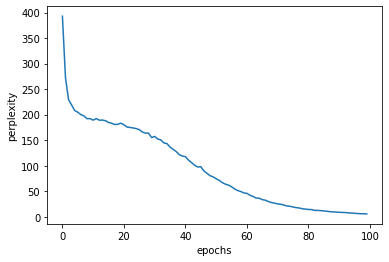

In [13]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
#from common.optimizer import SGD
from dataset import ptb
#from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


In [14]:
"""
말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 392.73
| 에폭 2 | 퍼플렉서티 272.01
| 에폭 3 | 퍼플렉서티 229.42
| 에폭 4 | 퍼플렉서티 218.85
| 에폭 5 | 퍼플렉서티 207.97
| 에폭 6 | 퍼플렉서티 204.74
| 에폭 7 | 퍼플렉서티 200.02
| 에폭 8 | 퍼플렉서티 197.43
| 에폭 9 | 퍼플렉서티 192.05
| 에폭 10 | 퍼플렉서티 192.27
| 에폭 11 | 퍼플렉서티 189.15
| 에폭 12 | 퍼플렉서티 192.33
| 에폭 13 | 퍼플렉서티 189.11
| 에폭 14 | 퍼플렉서티 189.45
| 에폭 15 | 퍼플렉서티 188.09
| 에폭 16 | 퍼플렉서티 184.72
| 에폭 17 | 퍼플렉서티 183.09
| 에폭 18 | 퍼플렉서티 180.70
| 에폭 19 | 퍼플렉서티 181.07
| 에폭 20 | 퍼플렉서티 183.36
| 에폭 21 | 퍼플렉서티 180.19
| 에폭 22 | 퍼플렉서티 175.71
| 에폭 23 | 퍼플렉서티 174.92
| 에폭 24 | 퍼플렉서티 173.96
| 에폭 25 | 퍼플렉서티 172.74
| 에폭 26 | 퍼플렉서티 170.59
| 에폭 27 | 퍼플렉서티 166.03
| 에폭 28 | 퍼플렉서티 163.82
| 에폭 29 | 퍼플렉서티 163.78
| 에폭 30 | 퍼플렉서티 155.20
| 에폭 31 | 퍼플렉서티 157.31
| 에폭 32 | 퍼플렉서티 152.22
| 에폭 33 | 퍼플렉서티 150.69
| 에폭 34 | 퍼플렉서티 144.60
| 에폭 35 | 퍼플렉서티 143.27
| 에폭 36 | 퍼플렉서티 136.49
| 에폭 37 | 퍼플렉서티 132.10
| 에폭 38 | 퍼플렉서티 127.76
| 에폭 39 | 퍼플렉서티 121.69
| 에폭 40 | 퍼플렉서티 118.90
| 에폭 41 | 퍼플렉서티 117.72
| 에폭 42 | 퍼플렉서티 111.00
| 에폭 43 | 퍼플렉서티 106.07
| 에폭 44 | 퍼플렉서티 100.92
| 에폭 45 | 퍼플렉서티 97.40
| 에폭 46 | 퍼플렉서티 98.17
| 에폭 47 | 퍼플렉서티 90.00
| 에폭 48 | 퍼플렉서티 85.24
| 에폭 49 | 퍼플렉서티 80.44
| 에폭 50 | 퍼플렉서티 78.16
| 에폭 51 | 퍼플렉서티 74.41
| 에폭 52 | 퍼플렉서티 71.32
| 에폭 53 | 퍼플렉서티 66.89
| 에폭 54 | 퍼플렉서티 63.88
| 에폭 55 | 퍼플렉서티 62.11
| 에폭 56 | 퍼플렉서티 58.80
| 에폭 57 | 퍼플렉서티 54.57
| 에폭 58 | 퍼플렉서티 51.36
| 에폭 59 | 퍼플렉서티 49.48
| 에폭 60 | 퍼플렉서티 46.73
| 에폭 61 | 퍼플렉서티 45.87
| 에폭 62 | 퍼플렉서티 42.12
| 에폭 63 | 퍼플렉서티 39.67
| 에폭 64 | 퍼플렉서티 36.73
| 에폭 65 | 퍼플렉서티 36.31
| 에폭 66 | 퍼플렉서티 33.56
| 에폭 67 | 퍼플렉서티 32.45
| 에폭 68 | 퍼플렉서티 29.80
| 에폭 69 | 퍼플렉서티 27.86
| 에폭 70 | 퍼플렉서티 26.77
| 에폭 71 | 퍼플렉서티 25.17
| 에폭 72 | 퍼플렉서티 24.48
| 에폭 73 | 퍼플렉서티 23.01
| 에폭 74 | 퍼플렉서티 21.05
| 에폭 75 | 퍼플렉서티 20.48
| 에폭 76 | 퍼플렉서티 19.20
| 에폭 77 | 퍼플렉서티 17.84
| 에폭 78 | 퍼플렉서티 17.24
| 에폭 79 | 퍼플렉서티 15.69
| 에폭 80 | 퍼플렉서티 15.01
| 에폭 81 | 퍼플렉서티 14.29
| 에폭 82 | 퍼플렉서티 14.06
| 에폭 83 | 퍼플렉서티 12.53
| 에폭 84 | 퍼플렉서티 12.42
| 에폭 85 | 퍼플렉서티 12.05
| 에폭 86 | 퍼플렉서티 11.45
| 에폭 87 | 퍼플렉서티 10.68
| 에폭 88 | 퍼플렉서티 9.98
| 에폭 89 | 퍼플렉서티 9.60
| 에폭 90 | 퍼플렉서티 9.22
| 에폭 91 | 퍼플렉서티 8.73
| 에폭 92 | 퍼플렉서티 8.49
| 에폭 93 | 퍼플렉서티 8.27
| 에폭 94 | 퍼플렉서티 7.63
| 에폭 95 | 퍼플렉서티 7.32
| 에폭 96 | 퍼플렉서티 6.79
| 에폭 97 | 퍼플렉서티 6.35
| 에폭 98 | 퍼플렉서티 5.91
| 에폭 99 | 퍼플렉서티 5.87
| 에폭 100 | 퍼플렉서티 5.56
"""

'\n말뭉치 크기: 1000, 어휘 수: 418\n| 에폭 1 | 퍼플렉서티 392.73\n| 에폭 2 | 퍼플렉서티 272.01\n| 에폭 3 | 퍼플렉서티 229.42\n| 에폭 4 | 퍼플렉서티 218.85\n| 에폭 5 | 퍼플렉서티 207.97\n| 에폭 6 | 퍼플렉서티 204.74\n| 에폭 7 | 퍼플렉서티 200.02\n| 에폭 8 | 퍼플렉서티 197.43\n| 에폭 9 | 퍼플렉서티 192.05\n| 에폭 10 | 퍼플렉서티 192.27\n| 에폭 11 | 퍼플렉서티 189.15\n| 에폭 12 | 퍼플렉서티 192.33\n| 에폭 13 | 퍼플렉서티 189.11\n| 에폭 14 | 퍼플렉서티 189.45\n| 에폭 15 | 퍼플렉서티 188.09\n| 에폭 16 | 퍼플렉서티 184.72\n| 에폭 17 | 퍼플렉서티 183.09\n| 에폭 18 | 퍼플렉서티 180.70\n| 에폭 19 | 퍼플렉서티 181.07\n| 에폭 20 | 퍼플렉서티 183.36\n| 에폭 21 | 퍼플렉서티 180.19\n| 에폭 22 | 퍼플렉서티 175.71\n| 에폭 23 | 퍼플렉서티 174.92\n| 에폭 24 | 퍼플렉서티 173.96\n| 에폭 25 | 퍼플렉서티 172.74\n| 에폭 26 | 퍼플렉서티 170.59\n| 에폭 27 | 퍼플렉서티 166.03\n| 에폭 28 | 퍼플렉서티 163.82\n| 에폭 29 | 퍼플렉서티 163.78\n| 에폭 30 | 퍼플렉서티 155.20\n| 에폭 31 | 퍼플렉서티 157.31\n| 에폭 32 | 퍼플렉서티 152.22\n| 에폭 33 | 퍼플렉서티 150.69\n| 에폭 34 | 퍼플렉서티 144.60\n| 에폭 35 | 퍼플렉서티 143.27\n| 에폭 36 | 퍼플렉서티 136.49\n| 에폭 37 | 퍼플렉서티 132.10\n| 에폭 38 | 퍼플렉서티 127.76\n| 에폭 39 | 퍼플렉서티 121.69\n| 에폭 40 | 퍼플렉서티 118.90\n| 에폭 41 | 퍼플렉서티 117.7

# common_all

In [2]:
#================================================================================#
#base_model.py
#================================================================================#


# coding: utf-8
import sys
sys.path.append('..')
import os
import pickle
#from common.np import *
#from common.util import to_gpu, to_cpu


class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]


#================================================================================#
#config.py
#================================================================================#
# coding: utf-8

GPU = False

#================================================================================#
#functions.py
#================================================================================#
# coding: utf-8
#from common.np import *


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


#================================================================================#
#layers.py
#================================================================================#

# coding: utf-8
#from common.np import *  # import numpy as np
#from common.config import GPU
#from common.functions import softmax, cross_entropy_error


class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

#================================================================================#
#layers.py
#================================================================================#

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None


#================================================================================#
#np.py
#================================================================================#

# coding: utf-8
#from common.config import GPU


if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
    np.add.at = np.scatter_add

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')
else:
    import numpy as np


#================================================================================#
#optimizer.py
#================================================================================#
# coding: utf-8
import sys
sys.path.append('..')
#from common.np import *


class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    '''
    모멘텀 SGG(Momentum SGD)
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    '''
    네스테로프 가속 경사(NAG; Nesterov's Accelerated Gradient) (http://arxiv.org/abs/1212.0901)
    '네스테로프 모멘텀 최적화'라고도 한다.
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    '''
    AdaGrad
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    '''
    RMSprop
    '''
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

#================================================================================#
#time_layers.py
#================================================================================#
# coding: utf-8
#from common.np import *  # import numpy as np (or import cupy as np)
#from common.layers import *
#from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

# ====================================================================== #
# 이 아래의 계층들은 책에서 설명하지 않았거나
# 처리 속도보다는 쉽게 이해할 수 있도록 구현했습니다.
#
# TimeSigmoidWithLoss: 시계열 데이터용 시그모이드 + 손실 계층
# GRU: GRU 계층
# TimeGRU: 시계열 데이터용 GRU 계층
# BiTimeLSTM: 양방향 LSTM 계층
# Simple_TimeSoftmaxWithLoss：간단한 TimeSoftmaxWithLoss 계층의 구현
# Simple_TimeAffine: 간단한 TimeAffine 계층의 구현
# ====================================================================== #


class TimeSigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.xs_shape = None
        self.layers = None

    def forward(self, xs, ts):
        N, T = xs.shape
        self.xs_shape = xs.shape

        self.layers = []
        loss = 0

        for t in range(T):
            layer = SigmoidWithLoss()
            loss += layer.forward(xs[:, t], ts[:, t])
            self.layers.append(layer)

        return loss / T

    def backward(self, dout=1):
        N, T = self.xs_shape
        dxs = np.empty(self.xs_shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t] = layer.backward(dout)

        return dxs


class GRU:
    def __init__(self, Wx, Wh):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        '''
        self.Wx, self.Wh = Wx, Wh
        self.dWx, self.dWh = None, None
        self.cache = None

    def forward(self, x, h_prev):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWx))
        self.dWh = np.hstack((dWhz, dWhr, dWh))

        return dx, dh_prev


class TimeGRU:
    def __init__(self, Wx, Wh, stateful=False):
        self.Wx, self.Wh = Wx, Wh
        selfdWx, self.dWh = None, None
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        N, T, D = xs.shape
        H, H3 = self.Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(self.Wx, self.Wh)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        N, T, H = dhs.shape
        D = self.Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        self.dWx, self.dWh = 0, 0

        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            self.dWx += layer.dWx
            self.dWh += layer.dWh

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class Simple_TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        layers = []
        loss = 0

        for t in range(T):
            layer = SoftmaxWithLoss()
            loss += layer.forward(xs[:, t, :], ts[:, t])
            layers.append(layer)
        loss /= T

        self.cache = (layers, xs)
        return loss

    def backward(self, dout=1):
        layers, xs = self.cache
        N, T, V = xs.shape
        dxs = np.empty(xs.shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = layers[t]
            dxs[:, t, :] = layer.backward(dout)

        return dxs


class Simple_TimeAffine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.dW, self.db = None, None
        self.layers = None

    def forward(self, xs):
        N, T, D = xs.shape
        D, M = self.W.shape

        self.layers = []
        out = np.empty((N, T, M), dtype='f')
        for t in range(T):
            layer = Affine(self.W, self.b)
            out[:, t, :] = layer.forward(xs[:, t, :])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, M = dout.shape
        D, M = self.W.shape

        dxs = np.empty((N, T, D), dtype='f')
        self.dW, self.db = 0, 0
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t, :] = layer.backward(dout[:, t, :])

            self.dW += layer.dW
            self.db += layer.db

        return dxs

#================================================================================#
#trainer.py
#================================================================================#
# coding: utf-8
import sys
sys.path.append('..')
import numpy
import time
import matplotlib.pyplot as plt
#from common.np import *  # import numpy as np
#from common.util import clip_grads


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()


def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


#================================================================================#
#util.py
#================================================================================#

# coding: utf-8
import sys
sys.path.append('..')
import os
#from common.np import *


def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성

    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M


def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

